# Exploratory Data Analysis

Looking at the Kaggle dataset [Realistic Loan Approval Dataset | US & Canada](https://www.kaggle.com/datasets/parthpatel2130/realistic-loan-approval-dataset-us-and-canada/data) for its major features, and preparing it for classification.


## Description of dataset from Author

1️⃣ Real-World Approval Logic The dataset implements actual banking criteria:

 - DTI ratio > 50% = automatic rejection
 - Defaults on file = instant reject
 - Credit score bands match real lending thresholds
 - Employment verification for loans ≥$20K


2️⃣ Realistic Correlations

 - Higher income → Better credit scores
 - Older applicants → Longer credit history
 - Students → Lower income, special treatment for small loans
 - Loan intent affects approval (Education best, Debt Consolidation worst)


3️⃣ Product-Specific Rules

 - Cards: More lenient, higher limits
 - Personal Loans: Standard criteria, up to $100K
 - Line of Credit: Capped at $50K, manual review for high amounts


4️⃣ Edge Cases Included

 - Young applicants (age 18) building first credit
 - Students with thin credit files
 - Self-employed with variable income
 - High debt-to-income ratios
 - Multiple delinquencies


## Exploration Steps

1. Fetch Data and Store Artifact
2. Initial Visual and Tabular Assessment
3. Data Cleaning
4. Model Training and Selection
5. Model Assessment Against Baseline

In [ ]:
# Python 3 Standard Library
import os
from pathlib import Path
import re

# if you are re-running this on your system, you'll probably need to change this path to match where you are storing these files
PROJECT_ROOT_PATH = Path(f"{os.environ['USERPROFILE']}\\OneDrive\\Education\\WGU\\Capstone")

# making sure I'm in the right directory for EDA, need to be in root
if not re.match(r'.*Capstone$', os.getcwd()):
    os.chdir(PROJECT_ROOT_PATH)

# Data Science Modules
## Data Analytics and Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

## Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Statistical Analysis
from mlxtend.evaluate import mcnemar_table
from statsmodels.stats.contingency_tables import mcnemar

# Custom modules
from src.utilities import new_logger, save_atomic

# Setting Pandas DataFrame options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

This is a module-wide logger that is tied to this notebook. During operation, it may also trigger writes to `logs/utils/src.utilities.log` when using `src.utilities` functions.

In [2]:
logger = new_logger("eda.data_exploration", "logs")

### 1. Fetch Data and Store Artifact

This dataset was downloaded locally as a CSV file.

I'm being careful to use `Path` in order to create absolute references to files on disk. This will help prevent odd behavior for relative references when run on other operating systems.

In [3]:
# Fetch local dataset
data_path = Path('data/Loan_approval_data_2025.csv').resolve()
logger.info(f"Attempting to fetch data from '{data_path}'")

loan_appr_df = pd.read_csv(data_path)
logger.info(f"Successfully created DataFrame {loan_appr_df.shape}")

In [4]:
# saving original in Parquet format for submission as artifact
orig_data_path_parquet = save_atomic(loan_appr_df, Path("data/loan_approval_data_2025.orig.parquet"), fmt="parquet")

### 2. Initial Visual and Tabular Assessment

#### Tabular Assessment (Directed and Non-Directed)

During this part of the process I am looking for multiple issues common to datasets from the Internet:
- Missing data
- Malformed data/typos
- Improper data ranges
- Improper data types

The first section deals with looking for missing data and dtypes, then we move on to looking at the correlations between numeric features as well as their distributions.

In [5]:
loan_appr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amount           

There doesn't seem to be any missing data. This makes sense because this is a synthetic dataset, though it is based on realistic business rules surrounding approving or denying loans.

In [6]:
loan_appr_df.isna().sum()

customer_id                0
age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64

Now I'll look for duplicated rows within the dataset. Since this is synthetically generated data, I don't expect to see any duplicated rows. This will exclude the `customer_id` column since that column will make each row unique by default.

A value of 0 indicates that there are not duplicated rows.

In [7]:
loan_appr_df.drop(columns=['customer_id']).duplicated().sum()

np.int64(0)

In [8]:
loan_appr_df.describe()

age  years_employed  annual_income  credit_score  \
count  50000.000000    50000.000000   50000.000000  50000.000000   
mean      34.957060        7.454868   50062.892040    643.614820   
std       11.118603        7.612097   32630.501014     64.731518   
min       18.000000        0.000000   15000.000000    348.000000   
25%       26.000000        1.300000   27280.500000    600.000000   
50%       35.000000        4.900000   41607.500000    643.000000   
75%       43.000000       11.400000   62723.250000    687.000000   
max       70.000000       39.900000  250000.000000    850.000000   

       credit_history_years  savings_assets   current_debt  defaults_on_file  \
count          50000.000000    50000.000000   50000.000000      50000.000000   
mean               8.168274     3595.619400   14290.442220          0.053480   
std                7.207552    13232.399398   13243.757493          0.224991   
min                0.000000        0.000000      60.000000          0.000000   
25%                2.000000      130.000000    5581.000000          0.000000   
50%                6.100000      568.000000   10385.000000          0.000000   
75%               12.600000     2271.000000   18449.250000          0.000000   
max               30.000000   300000.000000  163344.000000          1.000000   

       delinquencies_last_2yrs  derogatory_marks    loan_amount  \
count              50000.00000      50000.000000   50000.000000   
mean                   0.55464          0.147640   33041.874000   
std                    0.84505          0.412996   26116.185102   
min                    0.00000          0.000000     500.000000   
25%                    0.00000          0.000000   12300.000000   
50%                    0.00000          0.000000   26100.000000   
75%                    1.00000          0.000000   48500.000000   
max                    9.00000          4.000000  100000.000000   

       interest_rate  debt_to_income_ratio  loan_to_income_ratio  \
count   50000.000000          50000.000000          50000.000000   
mean       15.498591              0.285724              0.701999   
std         4.067942              0.159787              0.465788   
min         6.000000              0.002000              0.008000   
25%        12.180000              0.161000              0.333000   
50%        15.440000              0.265000              0.622000   
75%        18.870000              0.389000              1.010250   
max        23.000000              0.800000              2.001000   

       payment_to_income_ratio   loan_status  
count             50000.000000  50000.000000  
mean                  0.233995      0.550460  
std                   0.155268      0.497452  
min                   0.003000      0.000000  
25%                   0.111000      0.000000  
50%                   0.207000      1.000000  
75%                   0.337000      1.000000  
max                   0.667000      1.000000

The basic descriptive statistics for each numeric columns look reasonable based on my knowledge of each of these columns.

Now I'll do a non-directed assessment of the head, tail, and a random sample of rows within the dataset. This is an attempt to look for consistency throughout the data. I am also looking for situations where the columns should be joined, melted, or otherwise engineered to produce a better analysis.

In [9]:
loan_appr_df.head(25)

customer_id  age occupation_status  years_employed  annual_income  \
0   CUST100000   40          Employed            17.2          25579   
1   CUST100001   33          Employed             7.3          43087   
2   CUST100002   42           Student             1.1          20840   
3   CUST100003   53           Student             0.5          29147   
4   CUST100004   32          Employed            12.5          63657   
5   CUST100005   32          Employed            13.4          32015   
6   CUST100006   53          Employed            22.9          44989   
7   CUST100007   44     Self-Employed             4.2          80603   
8   CUST100008   29          Employed             5.9          28416   
9   CUST100009   41          Employed             7.0          70717   
10  CUST100010   29          Employed             5.0          15000   
11  CUST100011   29           Student             1.3          17029   
12  CUST100012   37          Employed             1.3          49084   
13  CUST100013   18          Employed             0.0          55958   
14  CUST100014   18     Self-Employed             1.0          99020   
15  CUST100015   28          Employed             0.4          59609   
16  CUST100016   22     Self-Employed             1.0          82604   
17  CUST100017   38          Employed             5.3          53356   
18  CUST100018   24          Employed             5.4          18675   
19  CUST100019   18     Self-Employed             1.0          55309   
20  CUST100020   52          Employed            31.3          75932   
21  CUST100021   32          Employed             1.3         109702   
22  CUST100022   35          Employed            16.9          68117   
23  CUST100023   18           Student             0.3          33556   
24  CUST100024   28     Self-Employed             5.4          59899   

    credit_score  credit_history_years  savings_assets  current_debt  \
0            692                   5.3             895         10820   
1            627                   3.5             169         16550   
2            689                   8.4              17          7852   
3            692                   9.8            1480         11603   
4            630                   7.2             209         12424   
5            570                   7.3             253          1120   
6            674                  11.1           19667         19298   
7            625                  18.5             830         38382   
8            569                   2.6            1334         22668   
9            638                  21.5            1578         21394   
10           657                   8.9            2105          3866   
11           668                   4.3             215          5592   
12           580                  11.3            1289         21106   
13           681                   1.4             378         14090   
14           561                   1.6             538         13733   
15           654                   2.6             881          9183   
16           605                   3.5            9216         16116   
17           671                  19.8            6339         23085   
18           531                   3.3              11          3280   
19           597                   1.5             346          2930   
20           695                   2.1            1283         10655   
21           720                  10.4            2790         42534   
22           698                  16.3             549         20450   
23           574                   1.5              91         10727   
24           567                   3.2           20476         27393   

    defaults_on_file  delinquencies_last_2yrs  derogatory_marks  \
0                  0                        0                 0   
1                  0                        1                 0   
2                  0                        0           

In [10]:
loan_appr_df.tail(25)

customer_id  age occupation_status  years_employed  annual_income  \
49975  CUST149975   21     Self-Employed             1.0          68454   
49976  CUST149976   38          Employed            10.3          27469   
49977  CUST149977   32          Employed             3.9          23132   
49978  CUST149978   53           Student             0.8          15000   
49979  CUST149979   18           Student             1.2          26627   
49980  CUST149980   35          Employed            10.5          28836   
49981  CUST149981   40     Self-Employed            16.2          36357   
49982  CUST149982   45           Student             0.1          27554   
49983  CUST149983   36          Employed             6.2          67472   
49984  CUST149984   39     Self-Employed             4.8         113630   
49985  CUST149985   37          Employed             1.9          28050   
49986  CUST149986   40          Employed             3.7          97505   
49987  CUST149987   34          Employed             5.3          32326   
49988  CUST149988   60           Student             1.2          67558   
49989  CUST149989   41          Employed            16.8          80369   
49990  CUST149990   37          Employed             9.4          37218   
49991  CUST149991   26          Employed             0.7          22159   
49992  CUST149992   30          Employed             9.3          24797   
49993  CUST149993   53          Employed            18.1          36948   
49994  CUST149994   18          Employed             0.0          64343   
49995  CUST149995   35          Employed             4.3          39449   
49996  CUST149996   34          Employed             4.4          20496   
49997  CUST149997   41     Self-Employed             4.8          18743   
49998  CUST149998   38           Student             0.4          17250   
49999  CUST149999   53          Employed            17.2          46923   

       credit_score  credit_history_years  savings_assets  current_debt  \
49975           552                   2.3            1371         24545   
49976           691                   8.5            2151         18801   
49977           560                  13.9             112          8077   
49978           591                  27.2             509          3882   
49979           546                   0.8              18          1634   
49980           524                   0.5              36          2558   
49981           601                  19.4            3526         22029   
49982           698                   9.6             665          1429   
49983           763                  10.6             264          5643   
49984           717                  10.8             422         37982   
49985           653                  18.6             476         15554   
49986           684                  13.9             854         33798   
49987           678                  14.7             585         12320   
49988           774                  13.4             647          2042   
49989           671                  14.2            2968         17515   
49990           588                  11.7            2389         13416   
49991           550                   3.7            1174         12699   
49992           610                   8.3              16          6282   
49993           676                   2.6              59         11421   
49994           585                   1.3             277         27914   
49995           570                  16.3            1127          7576   
49996           672                  12.6            1478          6276   
49997           719                  10.1              17         10331   
49998           633                   1.3               5          7779   
49999           695                  15.0            8332          2655   

       defaults_on_file  delinquencies_last_2yrs  derogatory_marks  \
49975                 0           

In [11]:
loan_appr_df.sample(25)

customer_id  age occupation_status  years_employed  annual_income  \
25331  CUST125331   42          Employed            12.1          30248   
11807  CUST111807   37          Employed            18.8          20389   
23440  CUST123440   48          Employed             0.7          63635   
14577  CUST114577   38          Employed             6.5          79971   
45601  CUST145601   31          Employed             4.6          41509   
3221   CUST103221   44     Self-Employed             2.7          37970   
11687  CUST111687   18          Employed             0.0          19044   
48804  CUST148804   41     Self-Employed            16.1          32535   
31192  CUST131192   62     Self-Employed             6.1          79443   
25821  CUST125821   58          Employed            33.6          92102   
88     CUST100088   28     Self-Employed             2.4          68946   
27785  CUST127785   51          Employed            24.6          38293   
6360   CUST106360   45          Employed            13.2          17564   
28402  CUST128402   22     Self-Employed             1.0          53501   
26736  CUST126736   23           Student             0.3          40968   
47058  CUST147058   20          Employed             1.7          24360   
18977  CUST118977   51           Student             0.6          15000   
30674  CUST130674   43     Self-Employed             3.9         128236   
12210  CUST112210   18           Student             0.5          17750   
12423  CUST112423   45     Self-Employed            11.2          15952   
27482  CUST127482   68          Employed            31.7          73941   
14527  CUST114527   41          Employed             2.1          46896   
24437  CUST124437   36          Employed            17.4          46585   
10487  CUST110487   46          Employed            13.7          41266   
550    CUST100550   36     Self-Employed             5.8          55282   

       credit_score  credit_history_years  savings_assets  current_debt  \
25331           678                   3.1              29         13993   
11807           618                   2.7             443         11298   
23440           639                   5.6             512         16107   
14577           665                  19.0             201         13383   
45601           713                   9.1             713          4700   
3221            682                  16.5            9276          6035   
11687           571                   1.6             371          2126   
48804           577                  16.5             865          9565   
31192           798                  10.0           14743          1565   
25821           683                   8.6             728         32623   
88              563                   9.6           10665         14467   
27785           632                  15.9             338         15144   
6360            570                   0.2               5          7838   
28402           590                   2.1             556         14676   
26736           756                   4.1             716          9519   
47058           546                   0.7              46          6256   
18977           570                   0.5              54          3186   
30674           594                  19.0          177309         21574   
12210           486                   1.9              39          6655   
12423           634                   1.6              10          7957   
27482           741                   6.7             269         11980   
14527           576                   4.1             196          9081   
24437           664                  12.5            2366         20361   
10487           706                  20.5             873         17543   
550             639                   8.4            2031          4011   

       defaults_on_file  delinquencies_last_2yrs  derogatory_marks  \
25331                 0           

#### Exploratory Visualizations

First, I isolate the columns into their various types. Since there are so few `object` columns, I will create that column grouping first, and then use it to narrow down to the numeric types. For ease of analysis, I will make two separate numeric groupings - one with the target variable `loan_status` and one without.

Then, the `obj_cols` group will be examined for repeated values - this indicate a good candidate for a categorical column.

Next, the `num_cols` will be analyzed using a correlation heatmap to look at relationships among variables. [I may also look at various slices of the data to see how relationships may change??]

Finally, I will take a look at the distributions of the `num_cols` group to get a sense of how normal each distribution is, or whether it has unique characteristics such as discrete values, or bimodality.

In [12]:
# Categorical columns, currently represented as `object` (string) dtypes
obj_cols = [col for col in loan_appr_df.dtypes[loan_appr_df.dtypes == 'object'].index if col != 'customer_id']

# all numerical columns including the `loan_status` target variable
num_cols_with_target = loan_appr_df.drop(columns=obj_cols).drop(columns=['customer_id']).columns.values

# all numerical columns excluding the `loan_status` target variable
num_cols = loan_appr_df.drop(columns=obj_cols).drop(columns=['customer_id', 'loan_status']).columns.values

#### Categorical Feature Exploration

Moving on to the object features, looking at the current possible values.

In [13]:
for col in obj_cols:
    print(f"{loan_appr_df[col].value_counts()}\n")

occupation_status
Employed         34971
Self-Employed    10179
Student           4850
Name: count, dtype: int64

product_type
Credit Card       22455
Personal Loan     17523
Line of Credit    10022
Name: count, dtype: int64

loan_intent
Personal              12429
Education             10134
Medical                7598
Business               7469
Home Improvement       7453
Debt Consolidation     4917
Name: count, dtype: int64



Based on what we can see above, these columns are all good candidates for becoming categorical. Let's look at the distributions of each feature to see if they make sense.

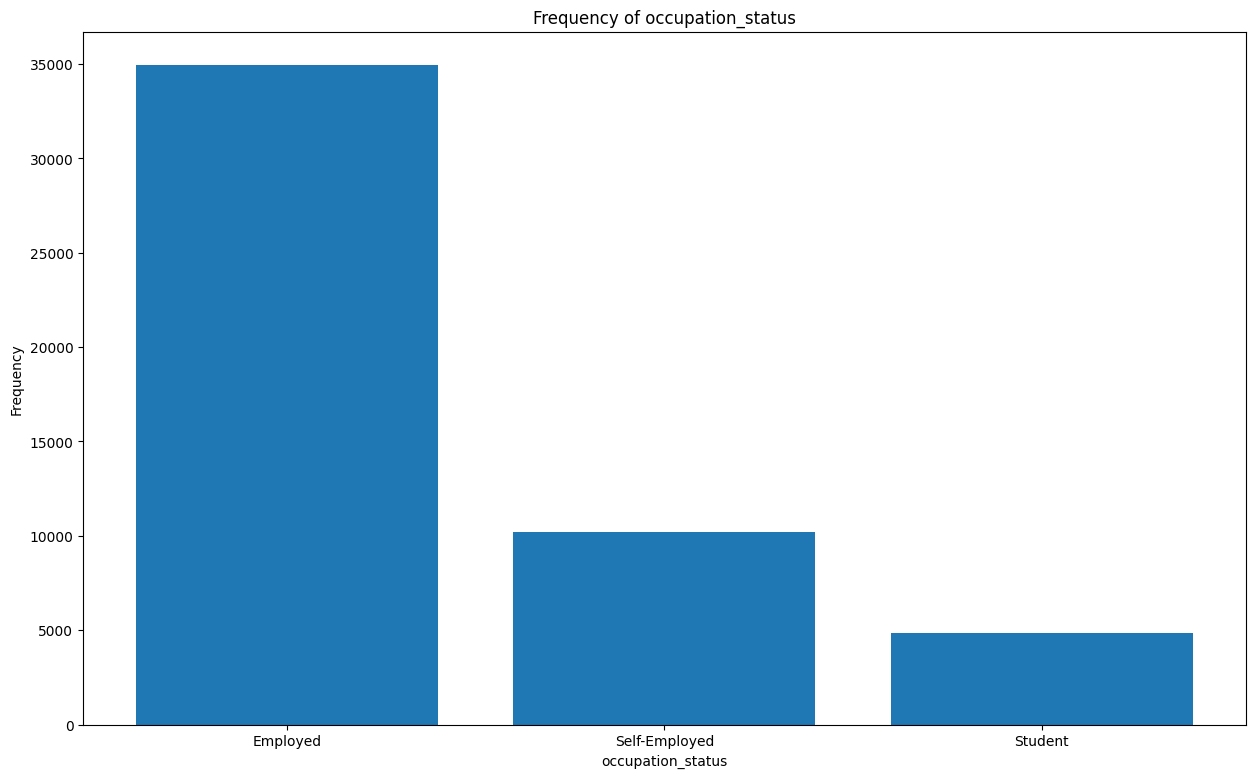

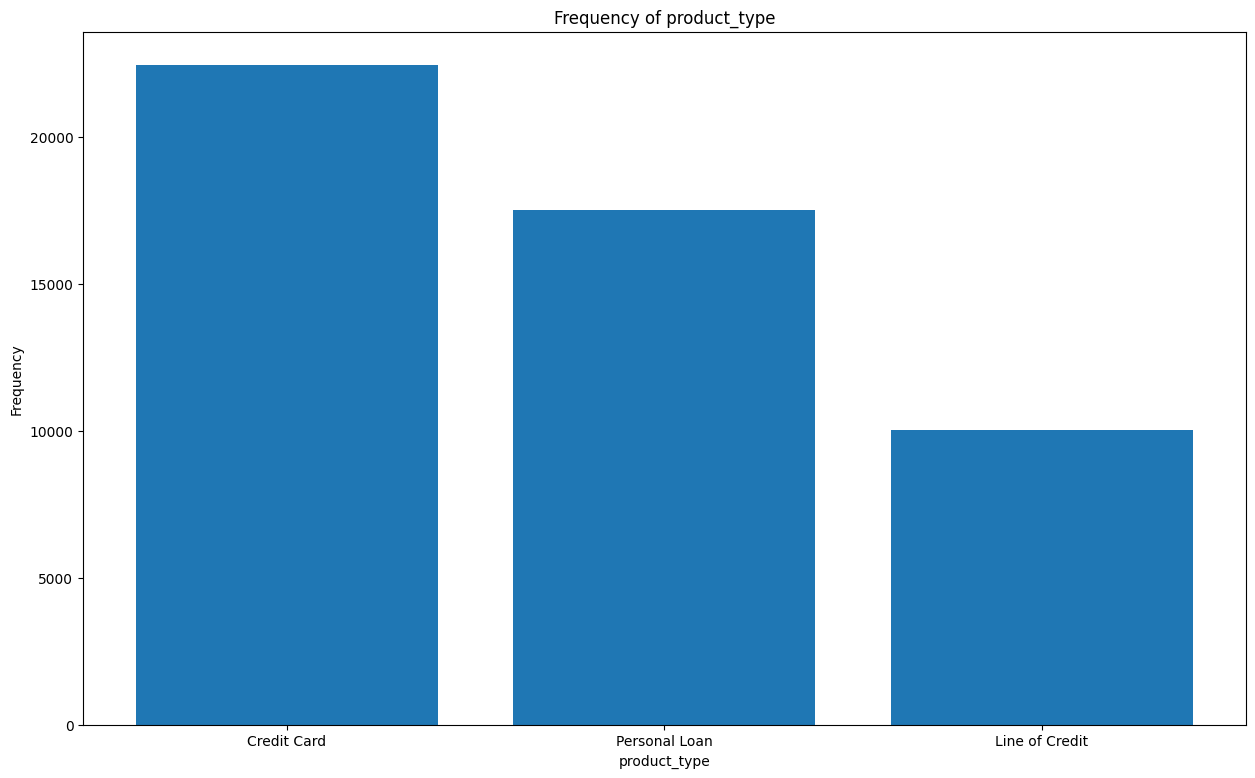

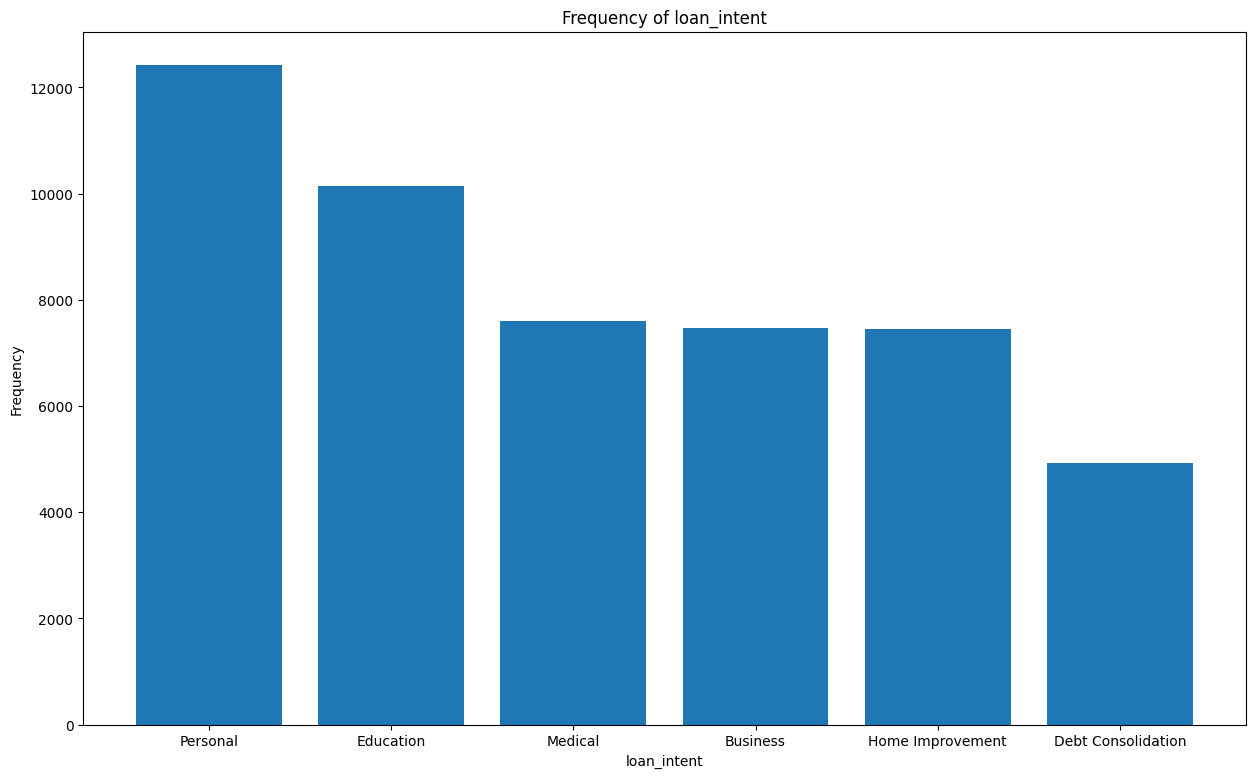

In [14]:
for col in obj_cols:
    val_counts = loan_appr_df[col].value_counts()
    fig, ax = plt.subplots(figsize=(15,9))
    ax.bar(val_counts.index.values, val_counts.values)
    ax.set_xlabel(val_counts.index.name)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Frequency of {val_counts.index.name}")

These categories seem like they make sense, and no changes are needed. This is expected from a synthetic dataset.

#### Numerical Feature Exploration

In [15]:
# create a correlation matrix with all of the numeric values
correlation_matrix = loan_appr_df[num_cols_with_target].corr()

Text(0.5, 1.0, 'Loan Application: Numeric Variables Correlation Heatmap')

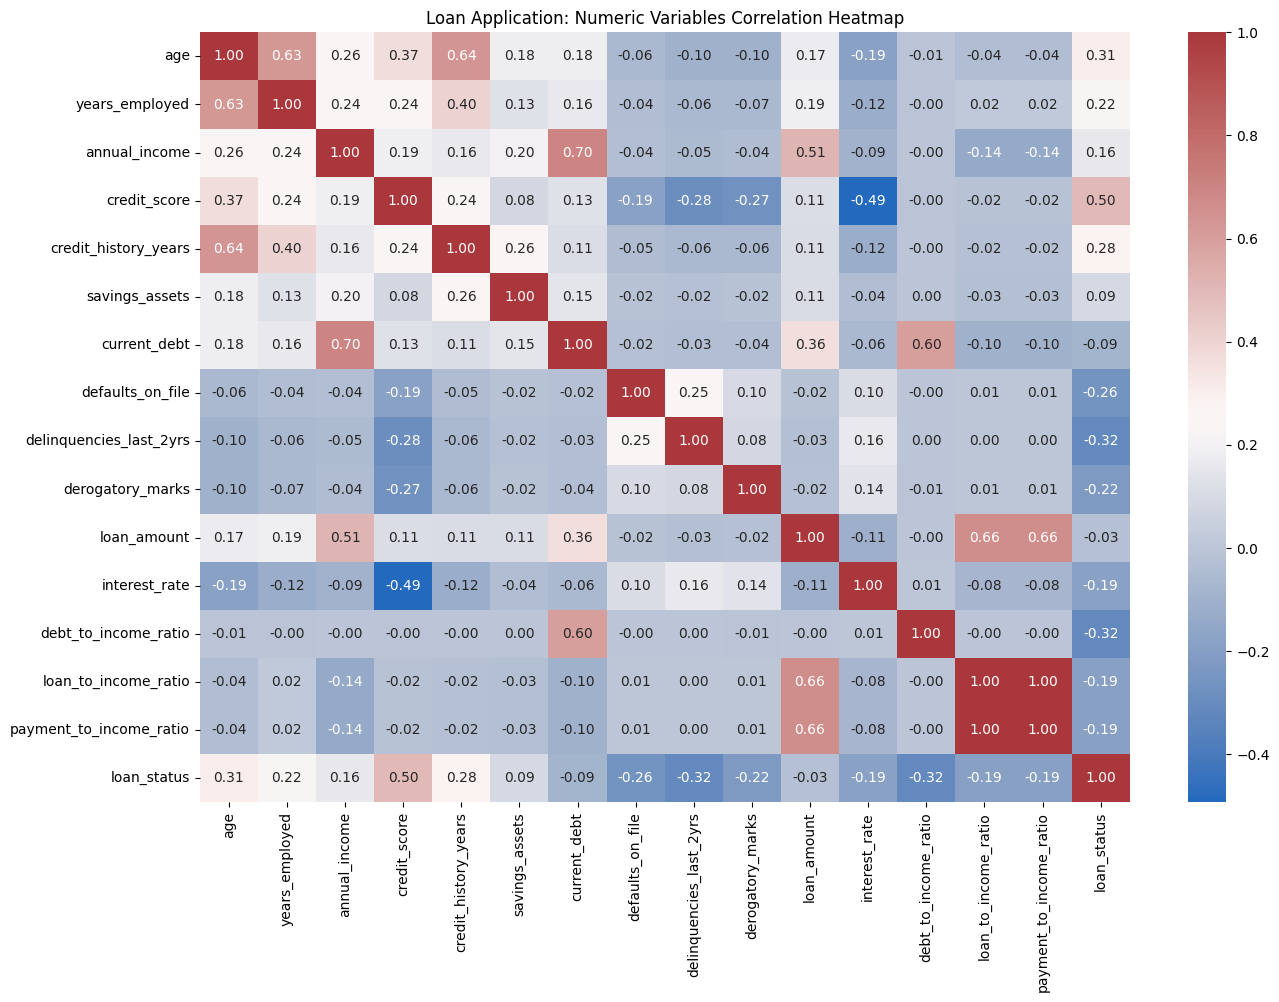

In [16]:
# create a Seaborn heatmap showing all of the correlation values
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap="vlag", fmt=".2f")
plt.title("Loan Application: Numeric Variables Correlation Heatmap")

Moving on, we can summarize how each numeric variable varies against every other numeric variable using Seaborn's `pairplot()` function. I will take a look at each distribution individually as well, below.

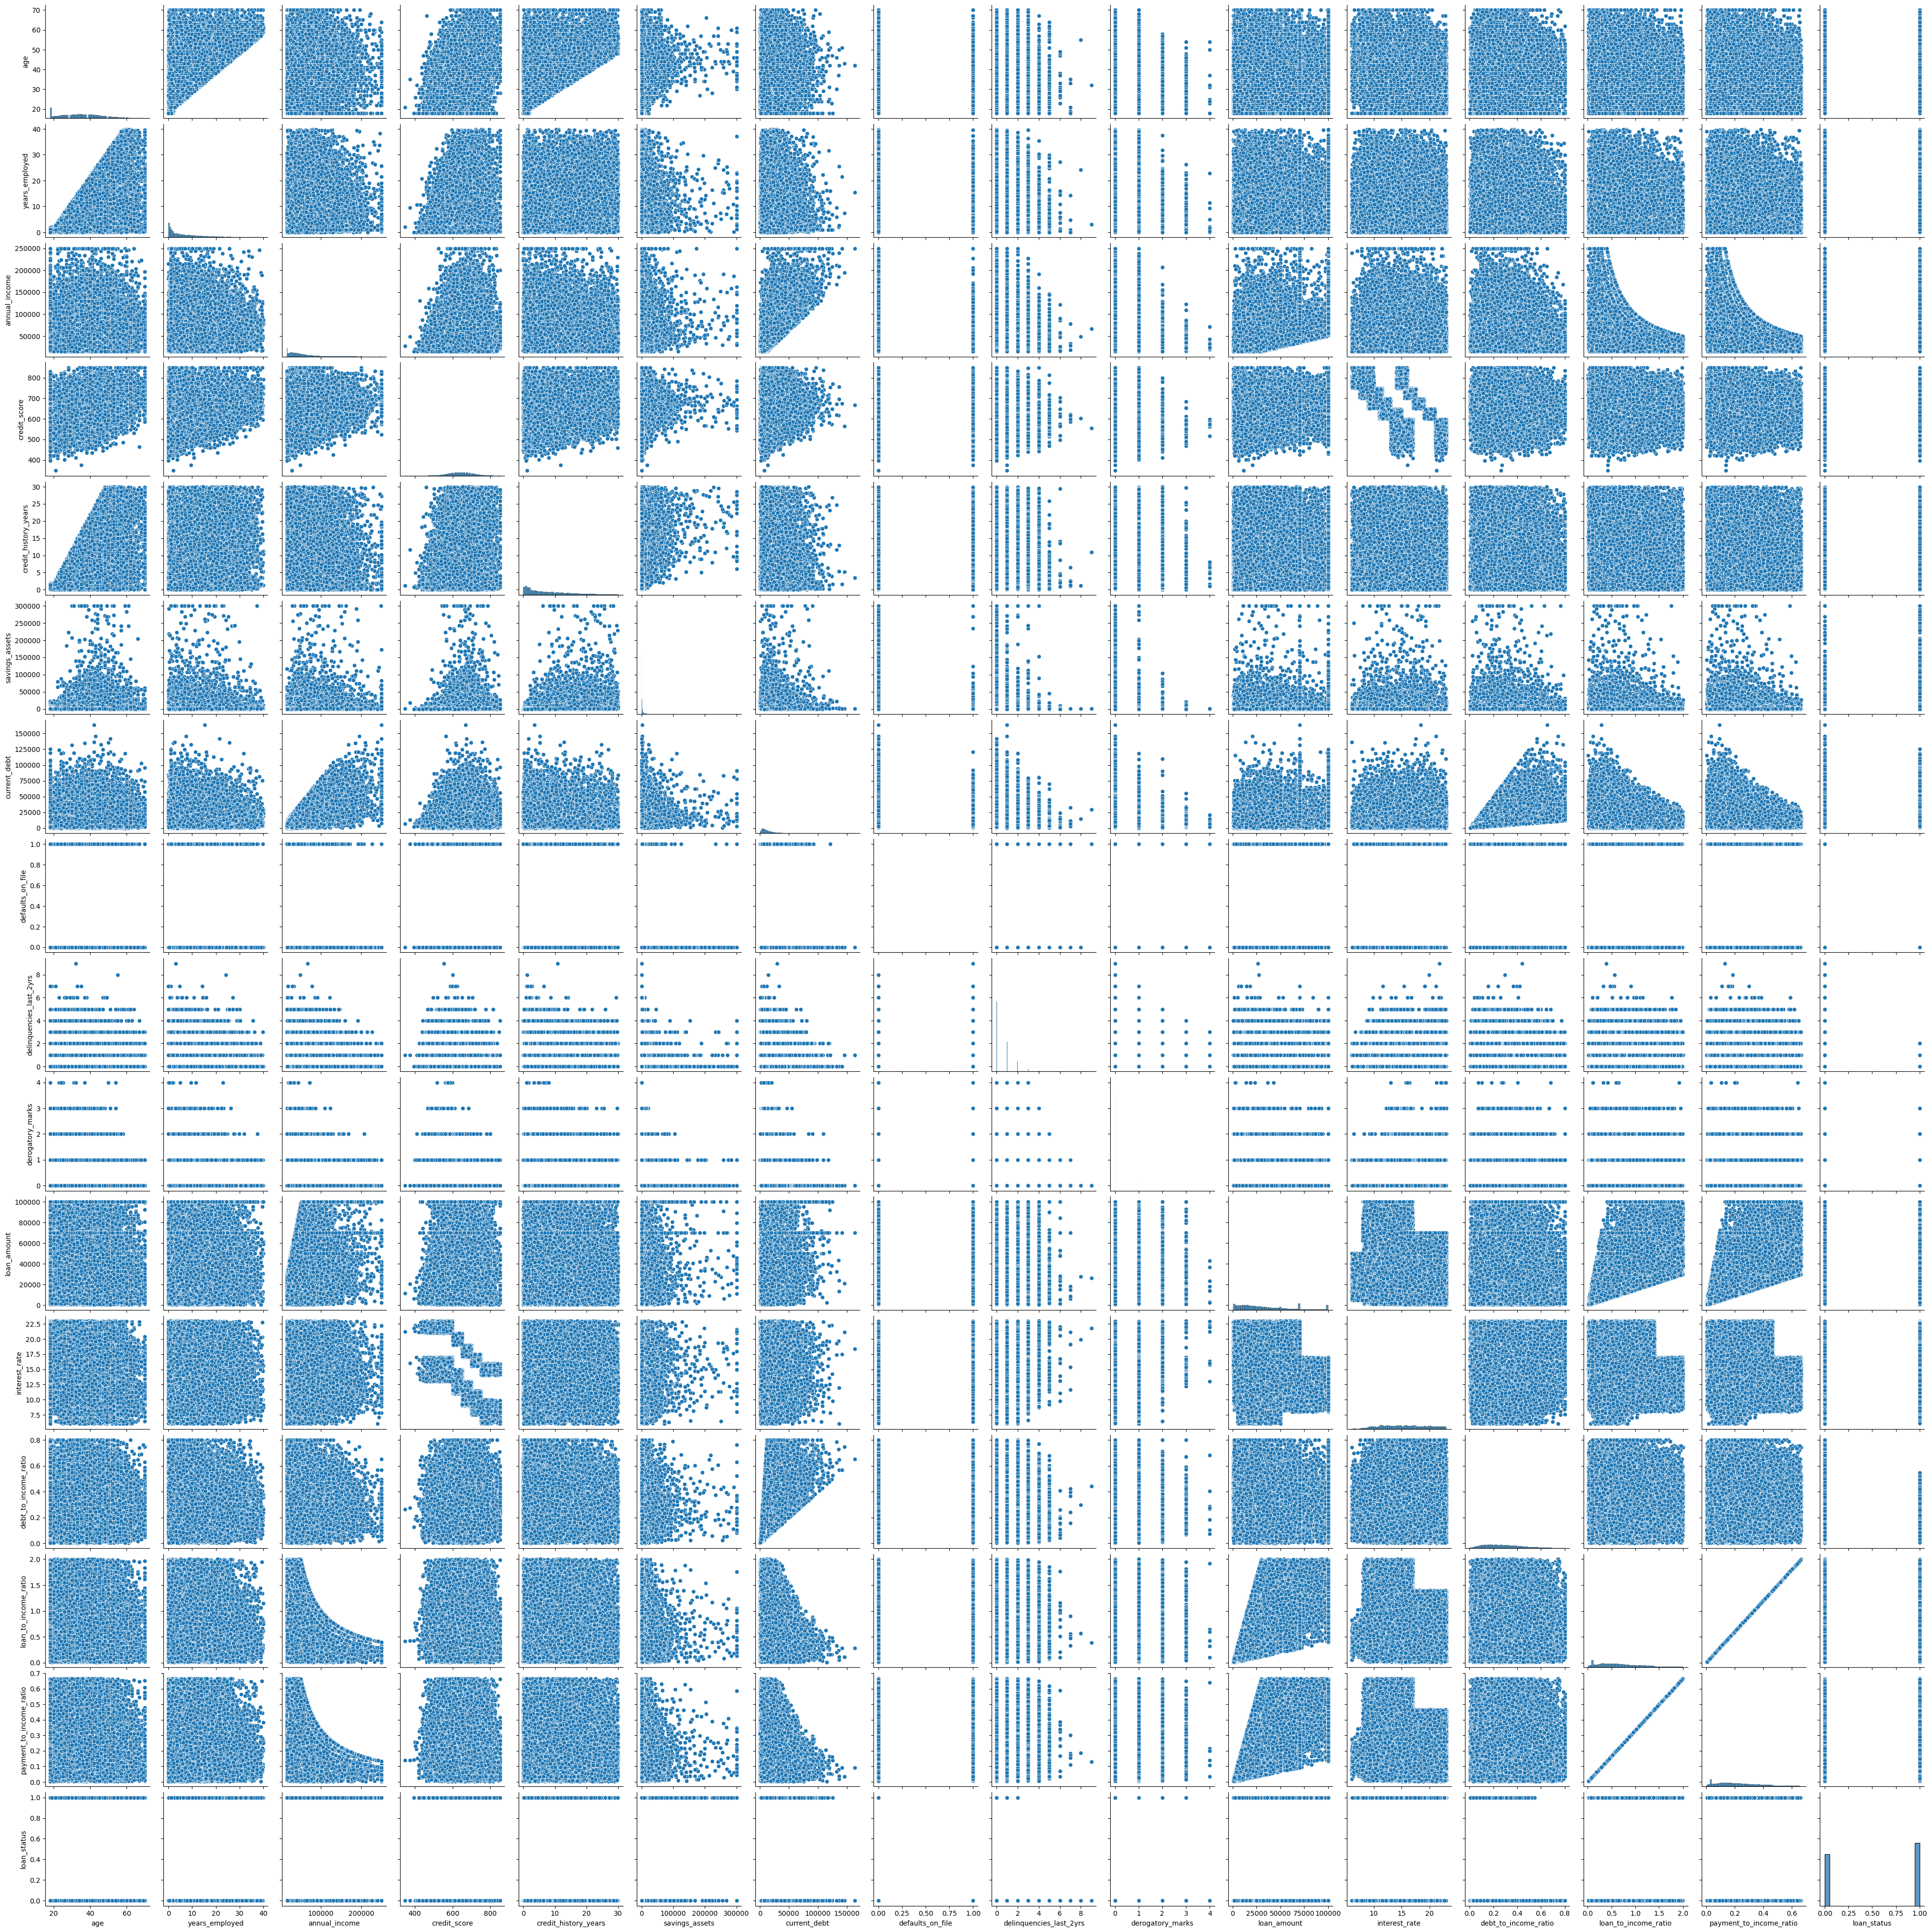

In [17]:
sns.pairplot(loan_appr_df[num_cols_with_target])

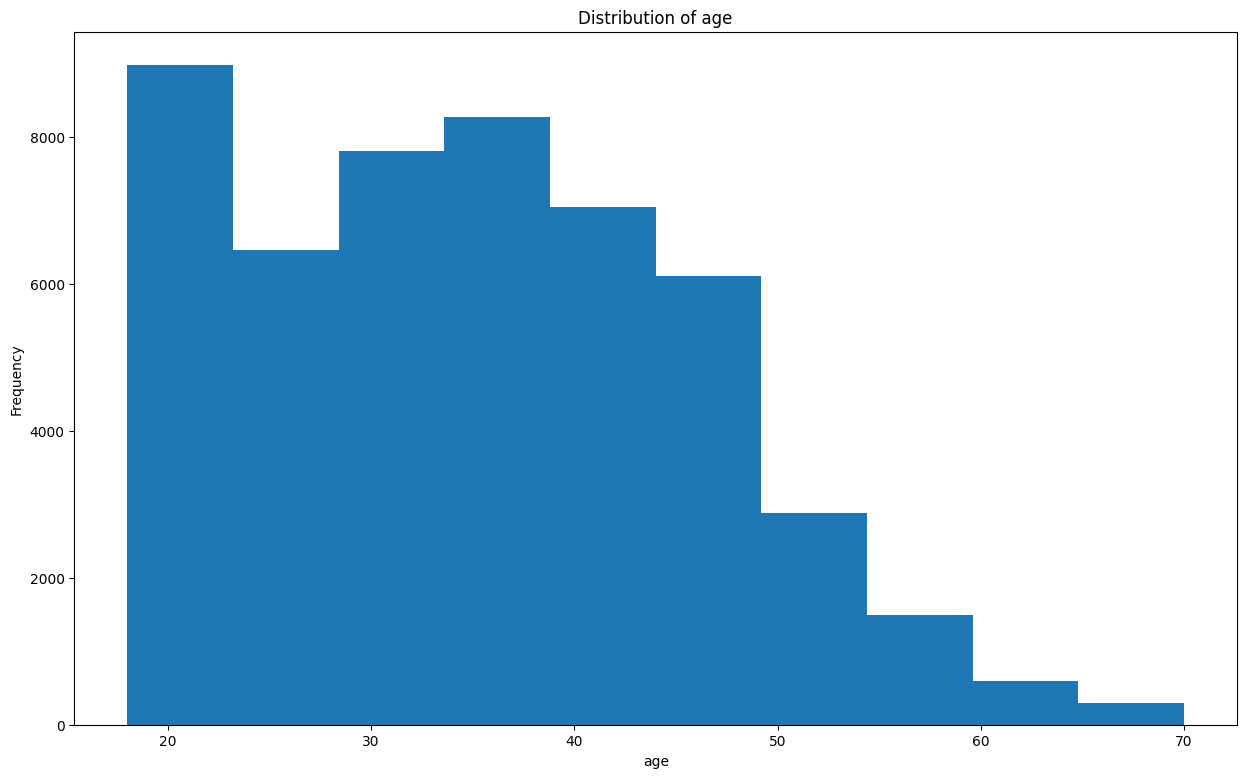

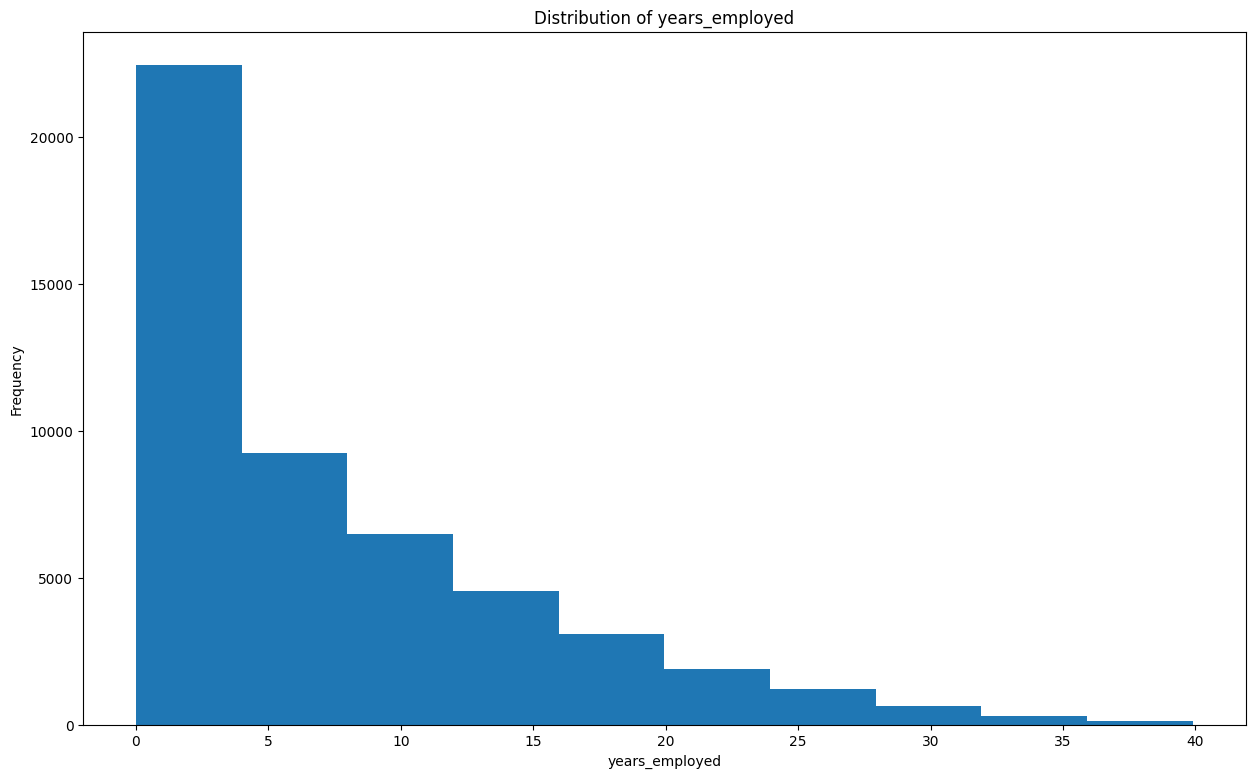

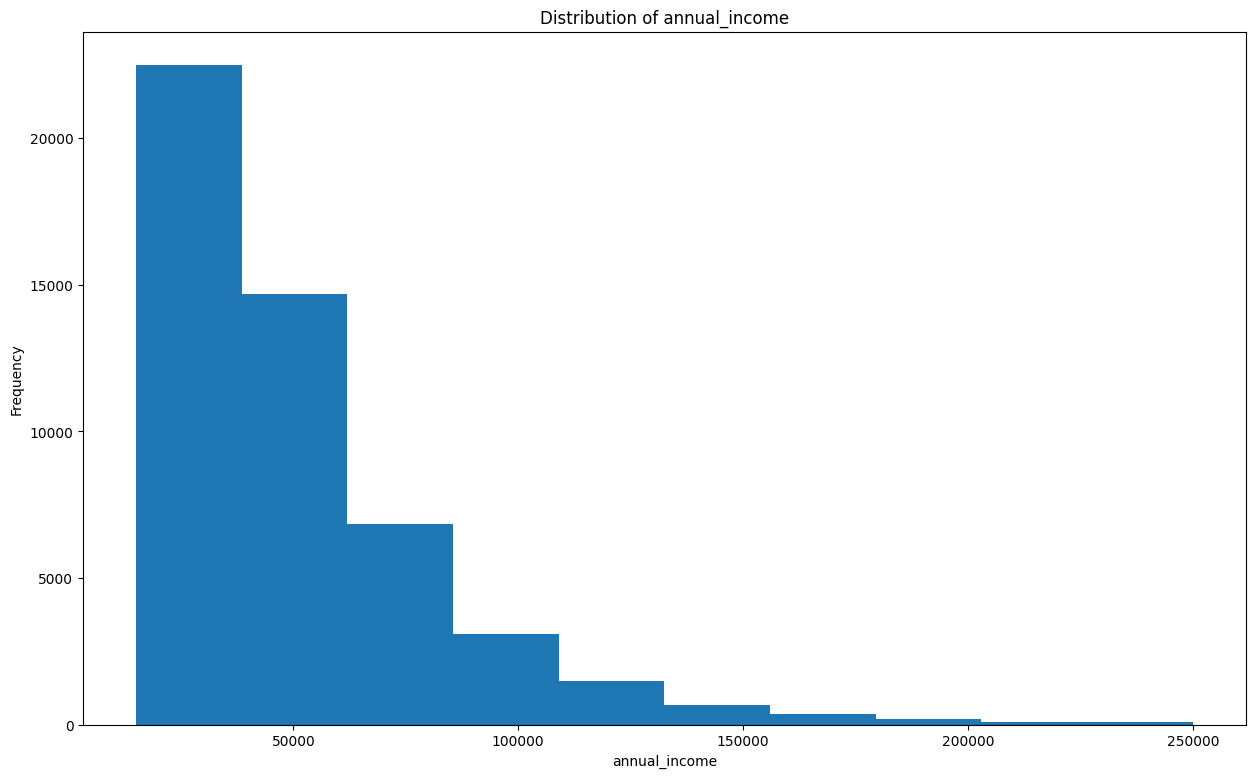

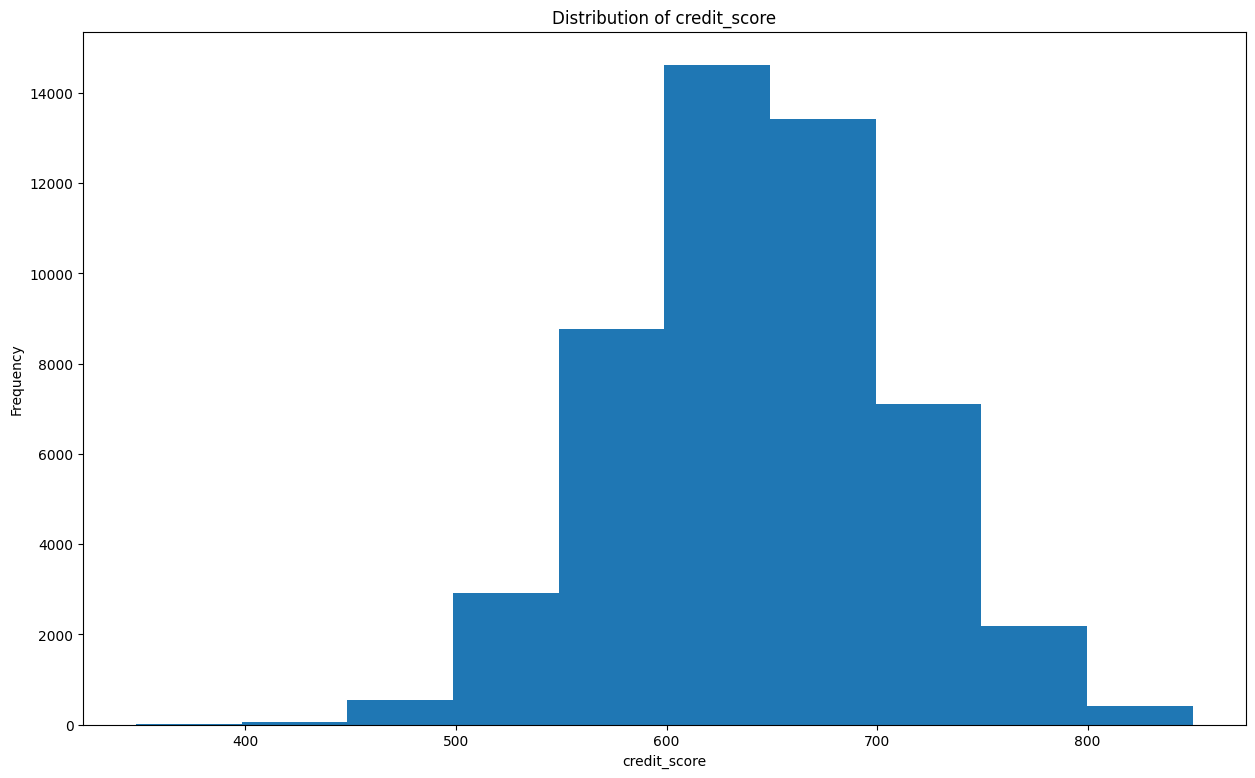

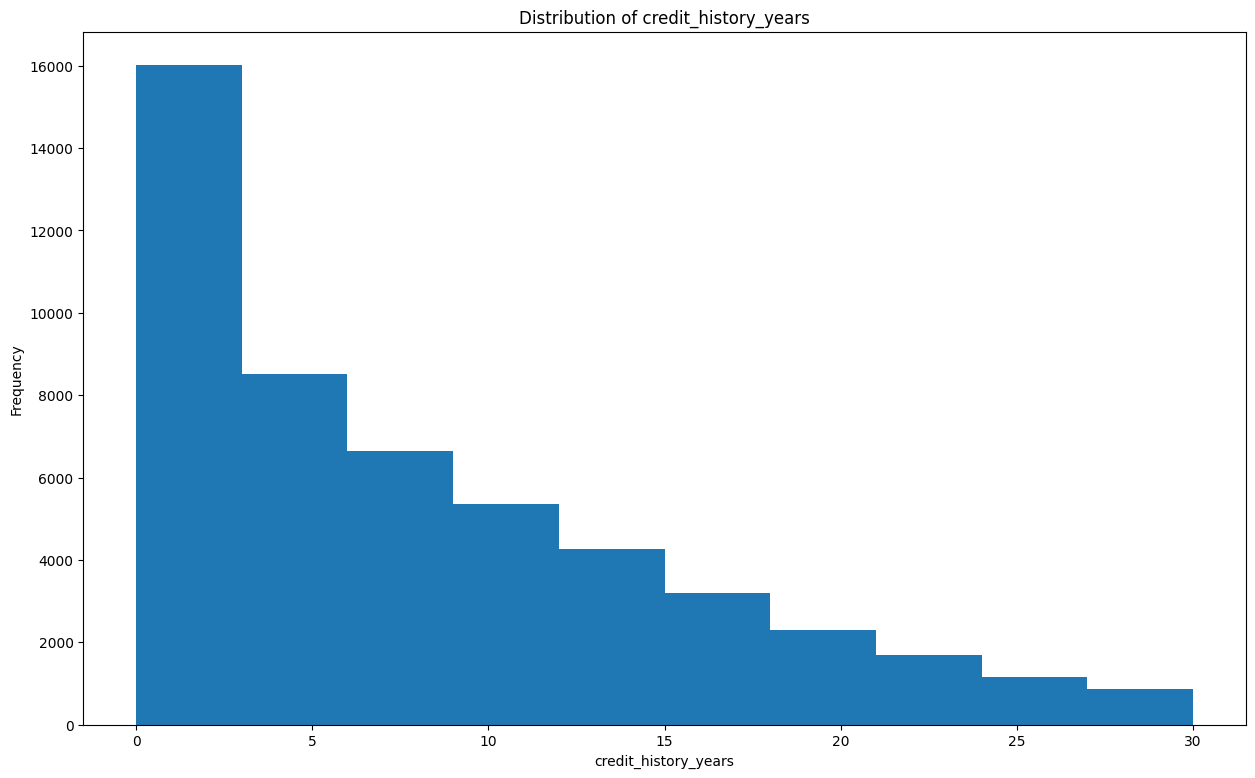

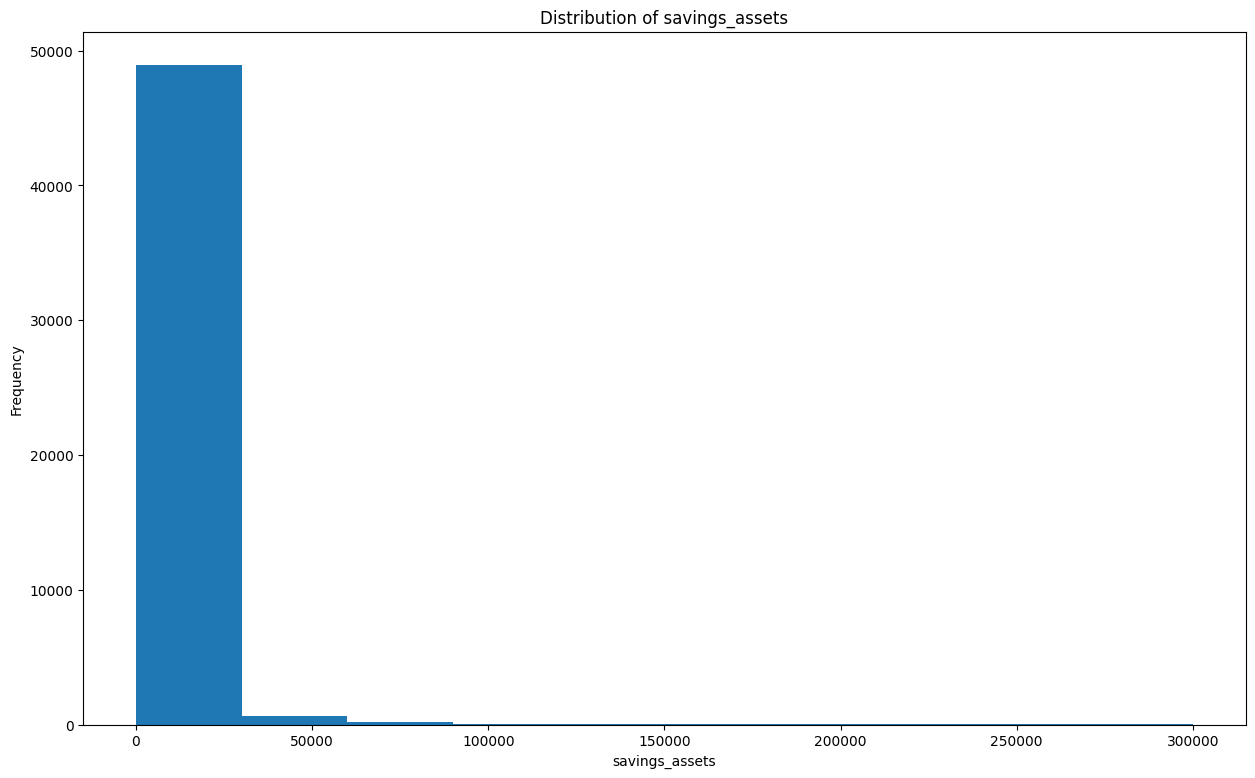

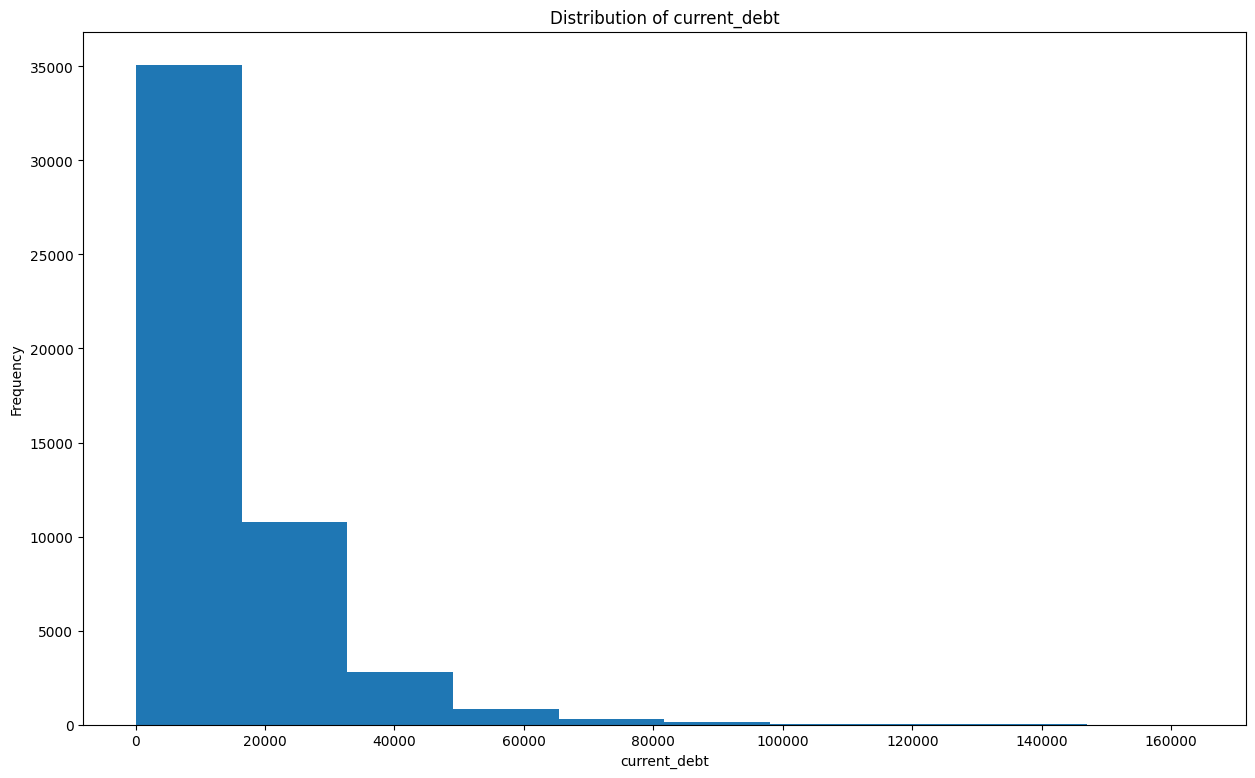

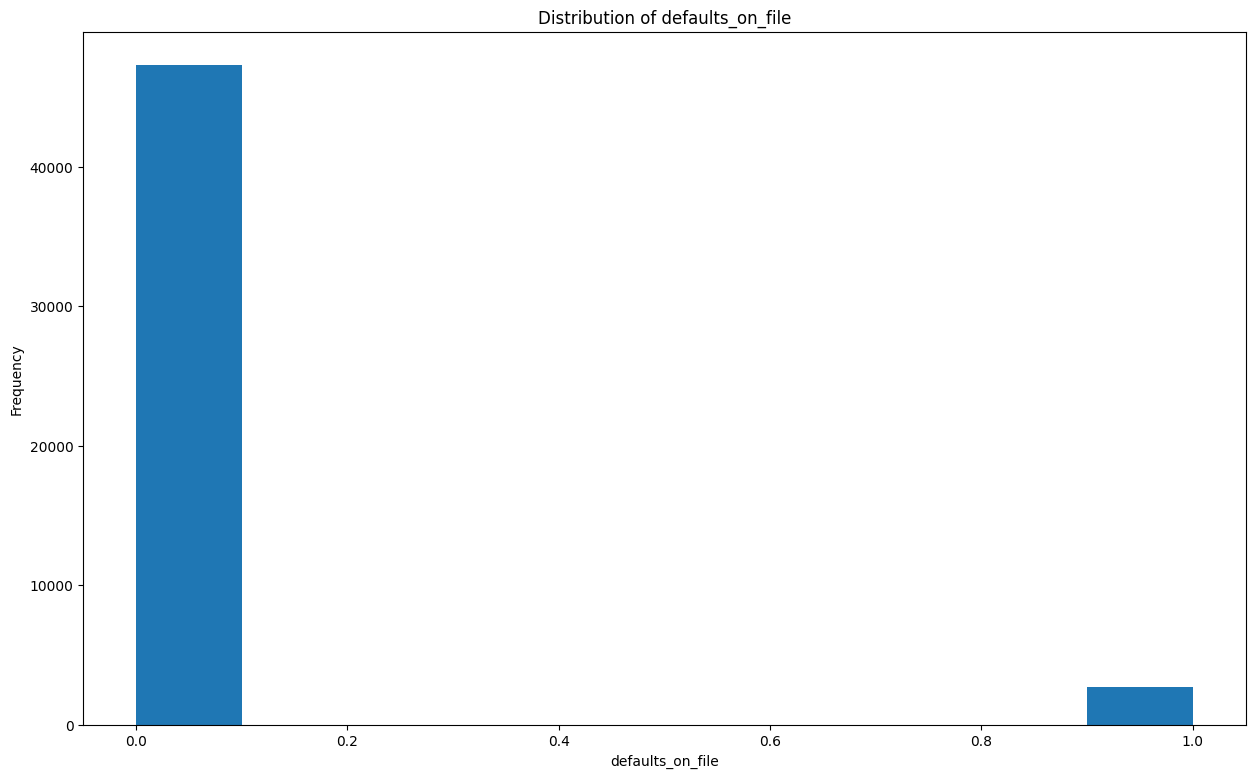

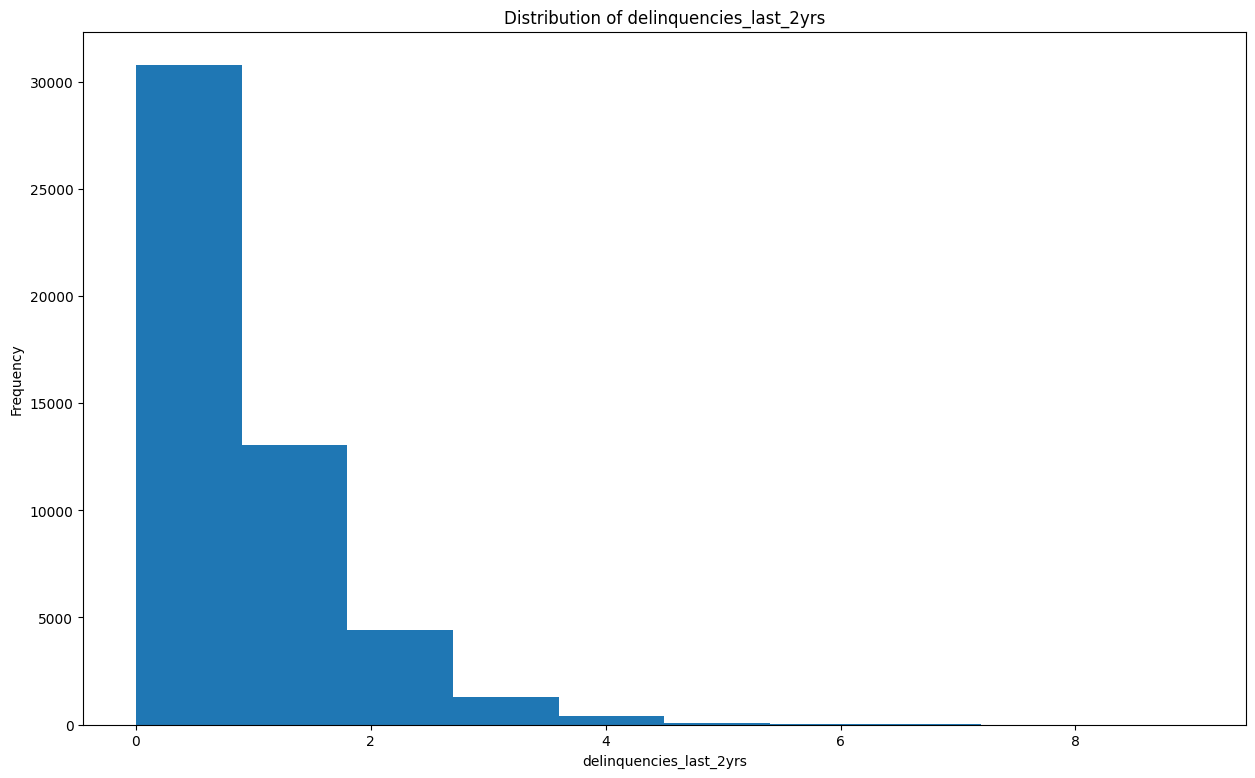

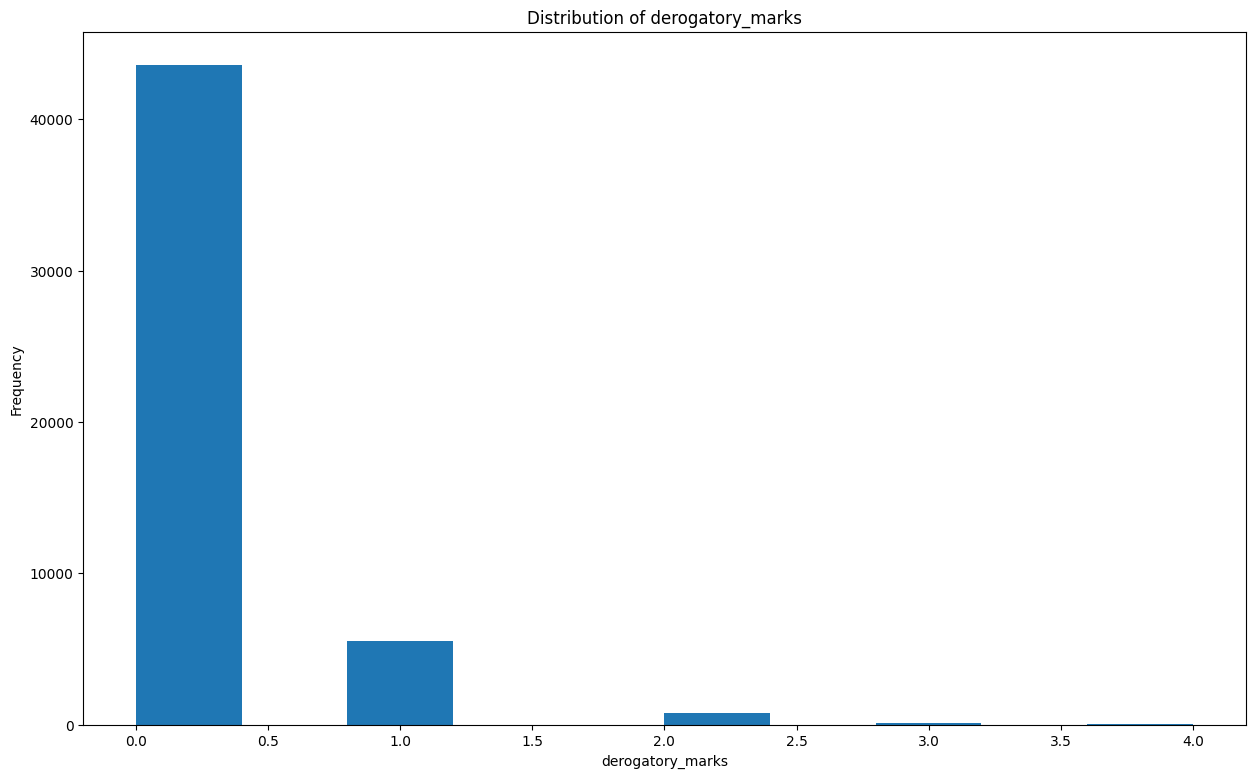

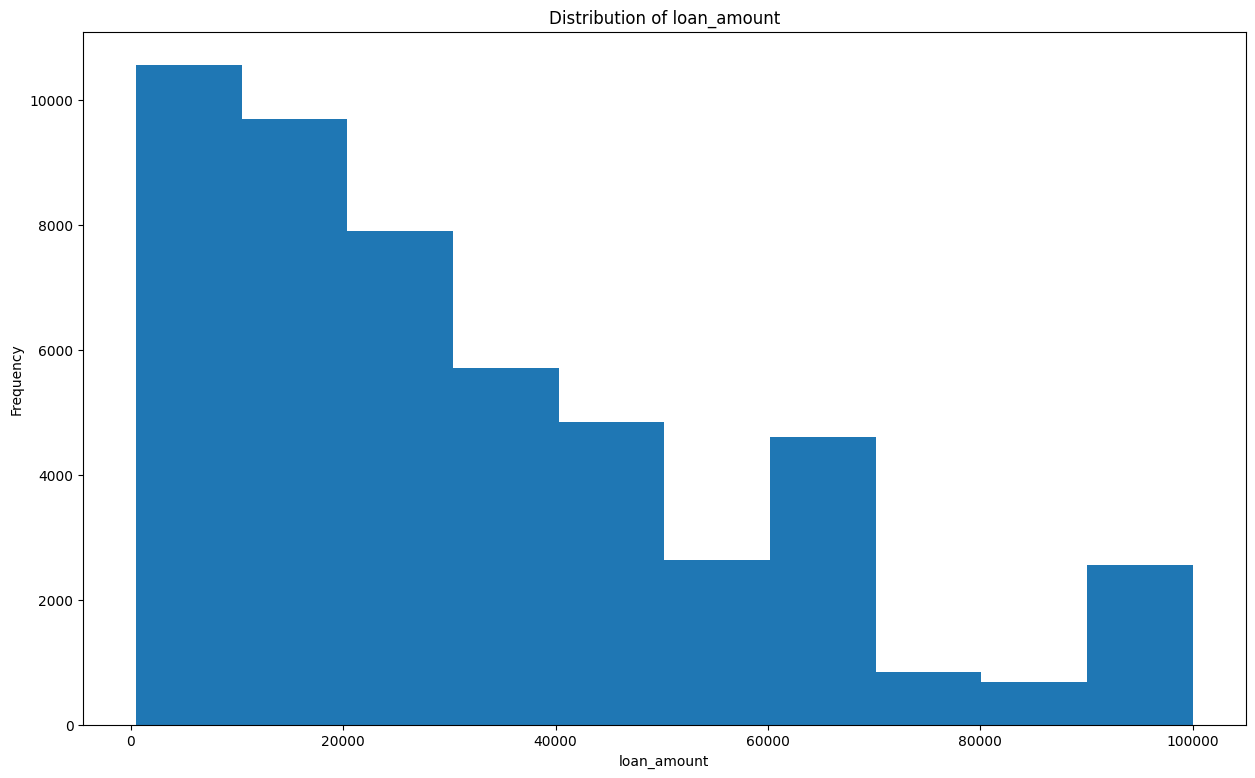

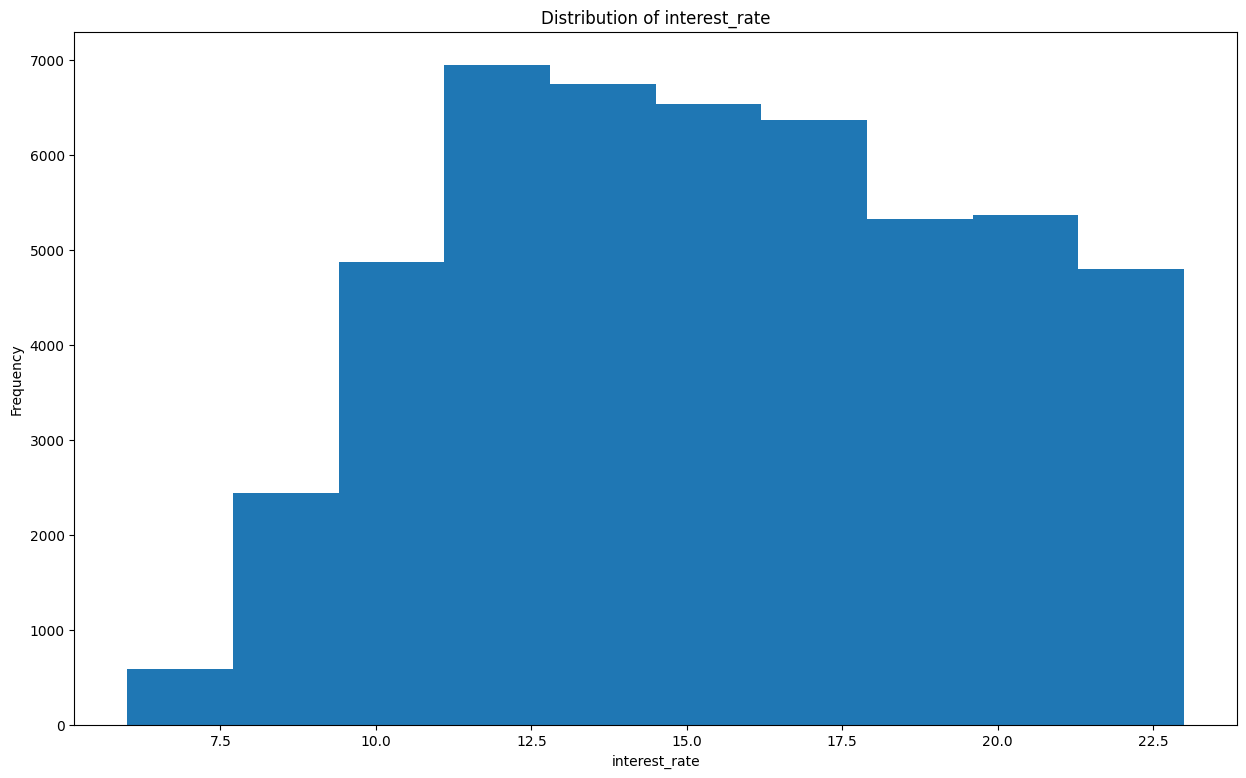

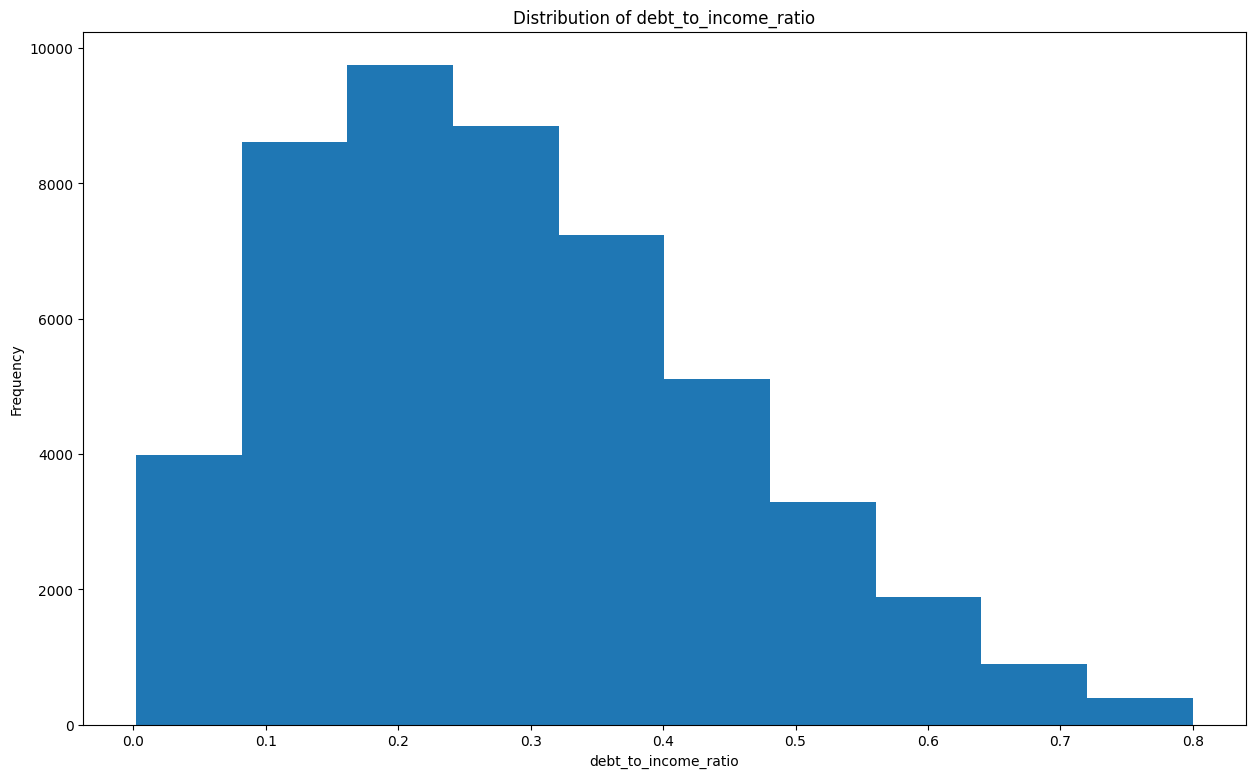

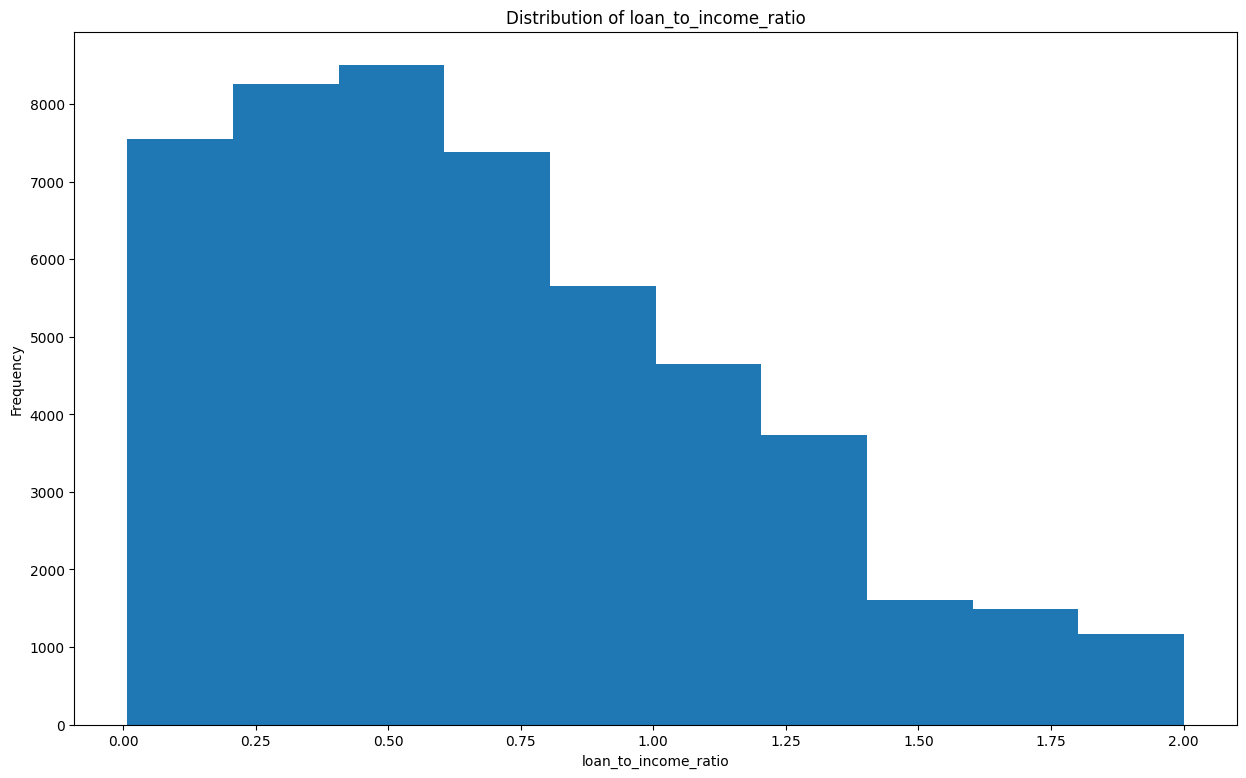

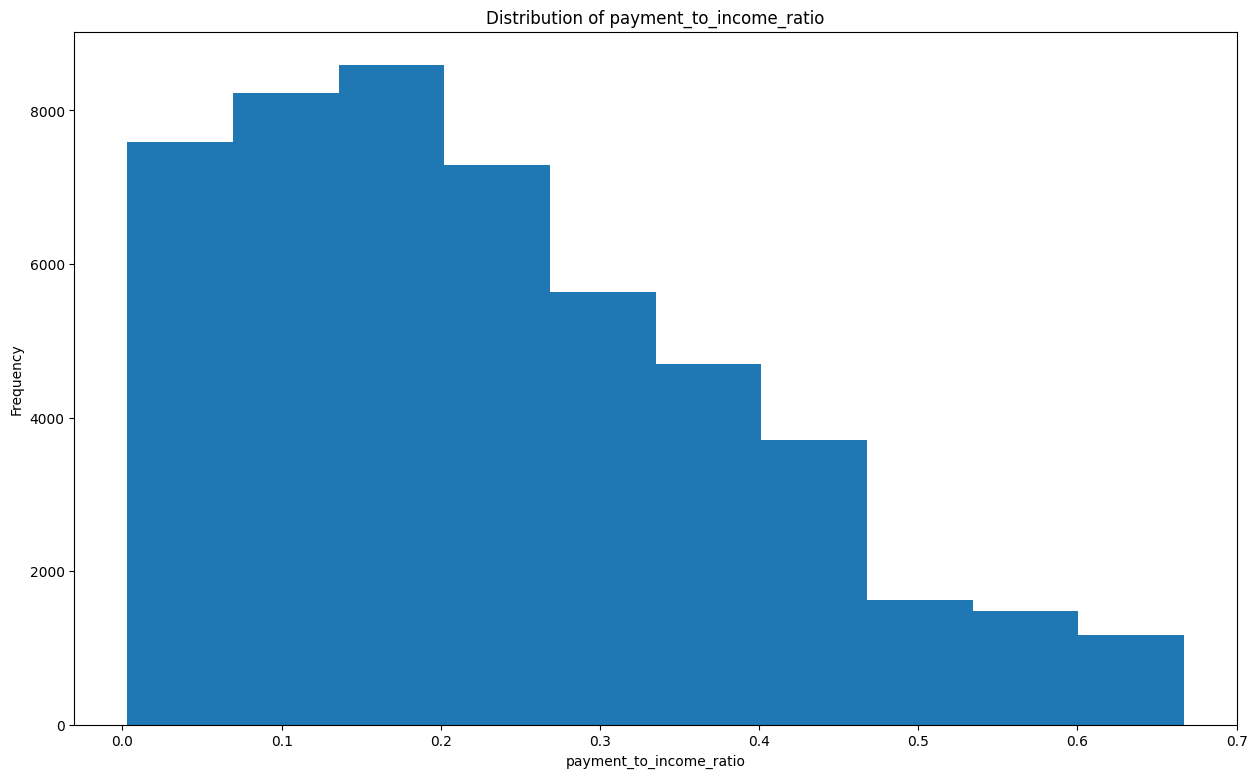

In [18]:
for col in num_cols:
    fig, ax = plt.subplots(figsize=(15,9))
    n, bins, patches = ax.hist(loan_appr_df[col])
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {col}")

These distributions look appropriate for each category, no major changes will be required. There is no case of "normal" distributions, which for looking at human populations is expected. The only "bimodal" feature seen is `loan_status` which doesn't really count since it's the binary response variable (the classification we're making).

Other non-continuous distributions are for `derogatory_marks`, `defaults_on_file`, and `delinquencies_last_2_years` are expected as these are discrete variables.

### 3. Data Cleaning

Based on what I can see in this dataset, there is barely any cleaning that must take place. Instead, there simply needs to be a pipeline to create a `OneHotEncoder` for the categorical columns and `StandardScaler` for the numeric columns for use in a Random Forest Classifier.

At this point, just dropping the customer ID column because it isn't useful in classification. This may have been able to be done earlier in the process as well. An alternative treatment is to use this column as the index, rather than the existing non-semantic index.

In addition, I will adjust the dtype of the object columns to be categorical for more efficient storage of data moving forward, and to solidify the idea that they are categories that will benefit from One-Hot Encoding before training the various models.

Finally, I have removed the `payment_to_income_ratio` column because it has perfect correlation with `loan_to_income_ratio` and does not add any value to this analysis.

In [19]:
# remove the unique Customer_ID identifier
loan_appr_wip = loan_appr_df.drop(columns=['customer_id', 'payment_to_income_ratio'])

In [20]:
# make each object feature a category feature instead
for col in obj_cols:
    loan_appr_wip[col] = loan_appr_wip[col].astype('category')

In [21]:
# save clean dataset as Parquet, for logging to W&B later
data_path = save_atomic(loan_appr_wip, Path("data/loan_approval_data_2025.clean.parquet"), fmt="parquet")

Now that cleaning is complete, let's perform a quick look at the clean DataFrame to make sure that the dtypes are correct and we still have no null values.

In [22]:
loan_appr_wip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      50000 non-null  int64   
 1   occupation_status        50000 non-null  category
 2   years_employed           50000 non-null  float64 
 3   annual_income            50000 non-null  int64   
 4   credit_score             50000 non-null  int64   
 5   credit_history_years     50000 non-null  float64 
 6   savings_assets           50000 non-null  int64   
 7   current_debt             50000 non-null  int64   
 8   defaults_on_file         50000 non-null  int64   
 9   delinquencies_last_2yrs  50000 non-null  int64   
 10  derogatory_marks         50000 non-null  int64   
 11  product_type             50000 non-null  category
 12  loan_intent              50000 non-null  category
 13  loan_amount              50000 non-null  int64   
 14  intere

Now I have to redefine the various column lists, since the WIP DataFrame is not the same as the original DataFrame.

In [23]:
# Categorical columns, currently represented as `object` (string) dtypes
obj_cols = [col for col in loan_appr_wip.dtypes[loan_appr_wip.dtypes == 'category'].index]

# all numerical columns including the `loan_status` target variable
num_cols_with_target = loan_appr_wip.drop(columns=obj_cols).columns.values

# all numerical columns excluding the `loan_status` target variable
num_cols = loan_appr_wip.drop(columns=obj_cols).drop(columns=['loan_status']).columns.values

In [24]:
obj_cols

['occupation_status', 'product_type', 'loan_intent']

### 4. Model Training and Selection

This section of the notebook provides the basis for the model training and selection process that will be implemented as a part of the completed MLOps pipeline.

First, I will split the X and y variables. Then, I will generate the training and testing sets. One alternative that may produce a better model is to perform cross-validation, switching up the training and testing sets to take full advantage of all of our available data. TODO: look into implementing cross-validation in this case, how would I treat the metrics and the model in that case?

Next, I will create a machine learning pipeline that includes the preprocessing steps for both the categorical (`OneHotEncoder`) and numeric (`StandardScaler`) variables. This ensures that the trained pipeline can be used for both training and inference as the same steps are being performed in both instances (provided the DataFrame columns are similar).

Finally, that machine learning pipeline will be trained using the `GridSearchCV` method for hyperparameter tuning. This will allow me to narrow in on which parameters are best for this scenario to reach the optimal hyperparameters for this dataset.

In [25]:
# split the data into X and y sets
y = loan_appr_wip.pop('loan_status')
X = loan_appr_wip

In [26]:
X.shape
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      50000 non-null  int64   
 1   occupation_status        50000 non-null  category
 2   years_employed           50000 non-null  float64 
 3   annual_income            50000 non-null  int64   
 4   credit_score             50000 non-null  int64   
 5   credit_history_years     50000 non-null  float64 
 6   savings_assets           50000 non-null  int64   
 7   current_debt             50000 non-null  int64   
 8   defaults_on_file         50000 non-null  int64   
 9   delinquencies_last_2yrs  50000 non-null  int64   
 10  derogatory_marks         50000 non-null  int64   
 11  product_type             50000 non-null  category
 12  loan_intent              50000 non-null  category
 13  loan_amount              50000 non-null  int64   
 14  intere

In [27]:
y.shape

(50000,)

In [28]:
# Building a column transformer out of OneHotEncoder and StandardScaler
logger.info("Starting inference training pipeline for all models")
cat_preproc = OneHotEncoder()
logger.debug(f"Created OneHotEncoder for columns {obj_cols}")
num_preproc = StandardScaler()
logger.debug(f"Created StandardScaler for columns {num_cols}")

preproc = ColumnTransformer(
    transformers=[
        ("cat_transform", cat_preproc, obj_cols),
        ("num_transform", num_preproc, num_cols)
    ],
    remainder='drop',
    verbose=True
)
logger.debug("Created ColumnTransformer for categorical and numerical preprocessing with all above columns. Any other columns will be dropped.")

In [ ]:
def nested_cross_validation(pipeline: Pipeline, X: pd.DataFrame, y: pd.Series, est_name: str, param_grid: dict[str, list], trials: int = 1, outer_cv_splits: int = 5, inner_cv_splits: int = 3, random_state: int = 72925, verbose: int = 0, n_jobs: int = -1) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Using a Machine Learning Pipeline and Parameter Grid, perform nested Cross-Validation and return a DataFrame with the results.

    Please not that this function can take a LONG time to run, if the hyperparameter space is large, or if the combined number of cross-validation folds and trials is very large.

    This function has a very high time-complexity, and should only be run if you have a lot of time to spare. To put this in common terms, if we have four hyperparameters with 3 options each, we have a hyperparameter space of 

    Args:
        pipeline (sklearn.pipeline.Pipeline):
            The machine learning Pipeline that contains the preprocessed columns and the model to use.
        X (pd.DataFrame):
            The X matrix to use for training and testing, contains only the predictor variables.
        y (pd.Series):
            the y array to use for training and testing, contains only the reponse variable.
        est_name (str):
            The estimator name, for logging.
        param_grid (dict[str, list]):
            A parameter grid dictionary with the parameter names as 'model__parameter' as keys and the list of hyperparameter options as the values.
        trials (int):
            The number of cross-validation trials to perform, defaults to 1.
        outer_cv_splits (int):
            The number of cross-validation splits for each trial, defaults to 5.
        inner_cv_splits (int):
            The number of hyperparameter tuning splits for each outer cross-validation fold, defaults to 3.
        random_state (int):
            The random state to use for better comparison across models. Defaults to 72925.
        verbose (int):
            The level of verbosity to use for the GridSearchCV and cross_validate methods, defaults to 0, letting the loops show the progress.
        n_jobs (int):
            The number of processors to use to parallelize the jobs. Defaults to -1.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]:
            pd.DataFrame: a `results` DataFrame with the trial, fold, model name, F-Beta, Accuracy, Precision, ROC_AUC, and the best hyperparameters for that model.
            
            pd.DataFrame: an `all_preds` DataFrame with the per-observation metrics for each trial/fold for each model. Contains the test indices, the actual test values, and the predicted test values, along with the model name to identify each round correctly.
    """
    logger.info(f"Starting nested cross-validation for {est_name}")
    logger.info(f"Using parameter grid for GridSearchCV: {param_grid}")

    results = [] # aggregate metrics
    all_preds = [] # per-observation predictions for McNemar's test

    # inner tqdm loop showing trials, from Walters 2022
    for t in tqdm(range(trials), desc=f"{est_name} Cross Validation Trials", leave=True):
        # define Inner CV Loop
        inner_cv = KFold(n_splits=inner_cv_splits, shuffle=True, random_state=random_state)
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grid,
            n_iter=30, # number of random samples
            verbose=verbose,
            cv=inner_cv,
            n_jobs=n_jobs,
            random_state=random_state
        )

        # define Outer CV Loop
        outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True, random_state=random_state)

        for fold_idx, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y)),total=outer_cv.get_n_splits(),desc=f"Trial {t} - {est_name} Outer Folds",leave=True):
            # fit the model
            random_search.fit(X.iloc[train_idx], y.iloc[train_idx])
            # obtain best estimator from this fitting round
            best_model = random_search.best_estimator_

            # best model's prediction
            y_pred = best_model.predict(X.iloc[test_idx]) # type: ignore
            # the actual results
            y_true = y.iloc[test_idx]

            # store aggregate metrics
            results.append({
                "trial": t,
                "fold": fold_idx,
                "model": est_name,
                "hyperparameters": random_search.best_params_,
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred),
                "fbeta": fbeta_score(y_true, y_pred, beta=0.5),
                "roc_auc": roc_auc_score(y_true, best_model.predict_proba(X.iloc[test_idx])[:,1]) # type: ignore
            })

            # store per-observation results
            all_preds.append({
                "trial": t,
                "fold": fold_idx,
                "model": est_name,
                "test_indices": test_idx,
                "y_true": y_true.values,
                "y_pred": y_pred
            })

    return pd.DataFrame(results), pd.DataFrame(all_preds)


To actually perform the training and tuning, run the following code with the model dictionary as follows. This contains all of the model names, their objects, and their hyperparameter grids.

In [36]:
model_definitions = [
    {
        "name": "Support Vector Machine",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', SVC(max_iter=-1,
                        random_state=72925, probability=True)) # Model step
        ]),
        "param_grid": {
            "clf__C": [10**x for x in range(-1,3)], # more reasonable C values
            "clf__kernel": ['rbf', 'poly'],
            "clf__degree": [2,3], # for 'poly' kernel only
            "clf__gamma": ['scale', 'auto'] # important for rbf kernel
        }
    },
    {
        "name": "Logistic Regression",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', LogisticRegression(penalty='l2', random_state=72925)) # Model step
        ]),
        "param_grid": {
            # C must be positive, starting with default value and moving up on log scale 4 places
            "clf__C": list(np.logspace(-4,4,4)),
            "clf__solver": ['lbfgs', 'sag', 'saga', 'newton-cholesky'],
            "clf__max_iter": [x for x in range(1000,2001,250)]
        }
    },
    {
        "name": "Gaussian Naive Bayes",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', GaussianNB()) # Model step
        ]),
        "param_grid": {
            "clf__var_smoothing": list(np.logspace(0,-9, num=100))
        }
    },
    {
        "name": "Adaptive Boosting",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', AdaBoostClassifier(random_state=72925)) # Model step
        ]),
        "param_grid": {
            "clf__n_estimators": [x for x in range(50,250,50)],
            "clf__learning_rate": [10**x for x in [-2,-1,0]]
        }
    },
    {
        "name": "Random Forest",
        "pipeline": Pipeline([
            ('preprocessing', preproc), # Preprocessing step
            ('clf', RandomForestClassifier()) # Model step
        ]),
        "param_grid": {
            'clf__n_estimators': [10**x for x in range(0,4)],
            'clf__max_features': ['sqrt'],
            'clf__max_depth': [x for x in range(1,6)],
            'clf__min_samples_split': [x*2 for x in range(1,6)]
        }
    },
]

In [38]:
# Saving in the middle of the runs
temp_results_path = Path('data/model_metrics.wip.parquet')
temp_predictions_path = Path('data/model_predictions.wip.parquet')
# Final save at the very end of the run
final_results_path = Path('data/model_metrics.final.parquet')
final_predictions_path = Path('data/model_predictions.final.parquet')

if not final_results_path.exists() or not final_predictions_path.exists():
    # Starting over, both files must be present in order to read them in
    if not temp_results_path.exists() or not temp_predictions_path.exists():
        # no files found on disk, create an empty DataFrame to start with
        # any existing files will be overwritten in the process
        all_results = pd.DataFrame()
        all_predictions = pd.DataFrame()
    else:
        # load the existing DataFrame and add to it without overwriting initially
        all_results = pd.read_parquet(temp_results_path)
        all_predictions = pd.read_parquet(temp_predictions_path)

    for model in tqdm(model_definitions, desc=f"Model Training - Main Experiment Loop", leave=True):
        logger.debug(f"Training iteration with {model['name']} as the inference model.")

        _result, _pred = nested_cross_validation(model['pipeline'], X, y, model['name'], model['param_grid'], trials=1, verbose=3)
        logger.debug(f"Results DataFrame for {model['name']} is complete with shape {_result.shape}")

        # log the specific _result DataFrame to disk for recovery purposes
        _model_results_path = Path(f"data/model_agg_results_{model['name'].lower().replace(' ', '-')}.wip.parquet")
        _model_predictions_path = Path(f"data/model_preds_{model['name'].lower().replace(' ', '-')}.wip.parquet")
        # save results to disk
        logger.info(f"Saving the results from the {model['name']} training runs to {_model_results_path} for safe-keeping.")
        save_atomic(_result, _model_results_path)
        # save predictions to disk
        logger.info(f"Saving the predictions from the {model['name']} training runs to {_model_predictions_path} for safe-keeping.")
        save_atomic(_result, _model_predictions_path)

        # add _result to all_results
        if all_results.shape[0] == 0:
            # empty DataFrame
            all_results = _result
            logger.debug(f"Initialized all_results DataFrame from the {model['name']} _result DataFrame.")
        else:
            # concatenating to DataFrame instead
            all_results = pd.concat([all_results, _result])
            logger.debug(f"Added the {model['name']} _result DataFrame to the existing all_results DataFrame. Current shape: {all_results.shape}")
        
        # add _pred to all_predictions
        if all_predictions.shape[0] == 0:
            # empty DataFrame
            all_predictions = _pred
            logger.debug(f"Initialized all_predictions DataFrame from the {model['name']} _pred DataFrame")
        else:
            # concatenating to existing DataFrame
            all_predictions = pd.concat([all_predictions, _pred])
            logger.debug(f"Added the {model['name']} _pred DataFrame to the existing all_predictions DataFrame. Current shape: {all_predictions.shape}")
        
        # log results DataFrame to disk so that it can be recovered on failure
        logger.info(f"Saving the results from all currently completed training runs to {temp_results_path} for safe-keeping.")
        save_atomic(all_results, temp_results_path)

        # log predictions DataFrame to disk so that it can be recovered on failure
        logger.info(f"Saving the predictions from all currently completed training runs to {temp_predictions_path} for safe-keeping.")
        save_atomic(all_predictions, temp_predictions_path)

    # if you reach this point, CONGRATS you are done, thanks for playing!
    logger.info(f"Saving the final results of training to {final_results_path}.")
    save_atomic(all_results, final_results_path)

    logger.info(f"Saving the final predictions from training to {final_predictions_path}.")
    save_atomic(all_predictions, final_predictions_path)
else:
    # final results have been created, load into DataFrame and don't repeat the process
    all_results = pd.read_parquet(final_results_path)
    all_predictions = pd.read_parquet(final_predictions_path)

Model Training - Main Experiment Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Support Vector Machine Cross Validation Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trial 0 - Support Vector Machine Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform,

Logistic Regression Cross Validation Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trial 0 - Logistic Regression Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_trans

Gaussian Naive Bayes Cross Validation Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trial 0 - Gaussian Naive Bayes Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_trans

Adaptive Boosting Cross Validation Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trial 0 - Adaptive Boosting Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform,

Random Forest Cross Validation Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trial 0 - Random Forest Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_transform, total=   0.0s
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[ColumnTransformer] . (1 of 2) Processing cat_transform, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing num_trans

In [39]:
all_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 4
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trial            25 non-null     int64  
 1   fold             25 non-null     int64  
 2   model            25 non-null     object 
 3   hyperparameters  25 non-null     object 
 4   accuracy         25 non-null     float64
 5   precision        25 non-null     float64
 6   fbeta            25 non-null     float64
 7   roc_auc          25 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.8+ KB


In [41]:
all_results

trial  fold                   model  \
0      0     0  Support Vector Machine   
1      0     1  Support Vector Machine   
2      0     2  Support Vector Machine   
3      0     3  Support Vector Machine   
4      0     4  Support Vector Machine   
0      0     0     Logistic Regression   
1      0     1     Logistic Regression   
2      0     2     Logistic Regression   
3      0     3     Logistic Regression   
4      0     4     Logistic Regression   
0      0     0    Gaussian Naive Bayes   
1      0     1    Gaussian Naive Bayes   
2      0     2    Gaussian Naive Bayes   
3      0     3    Gaussian Naive Bayes   
4      0     4    Gaussian Naive Bayes   
0      0     0       Adaptive Boosting   
1      0     1       Adaptive Boosting   
2      0     2       Adaptive Boosting   
3      0     3       Adaptive Boosting   
4      0     4       Adaptive Boosting   
0      0     0           Random Forest   
1      0     1           Random Forest   
2      0     2           Random Forest   
3      0     3           Random Forest   
4      0     4           Random Forest   

                                     hyperparameters  accuracy  precision  \
0  {'clf__kernel': 'rbf', 'clf__gamma': 'auto', '...    0.9093   0.910895   
1  {'clf__kernel': 'rbf', 'clf__gamma': 'auto', '...    0.9102   0.913168   
2  {'clf__kernel': 'rbf', 'clf__gamma': 'auto', '...    0.9119   0.918218   
3  {'clf__kernel': 'rbf', 'clf__gamma': 'auto', '...    0.9119   0.913479   
4  {'clf__kernel': 'rbf', 'clf__gamma': 'auto', '...    0.9125   0.915600   
0  {'clf__solver': 'lbfgs', 'clf__max_iter': 1500...    0.8685   0.876357   
1  {'clf__solver': 'lbfgs', 'clf__max_iter': 1500...    0.8612   0.866124   
2  {'clf__solver': 'sag', 'clf__max_iter': 1750, ...    0.8642   0.871493   
3  {'clf__solver': 'sag', 'clf__max_iter': 1750, ...    0.8742   0.876484   
4  {'clf__solver': 'sag', 'clf__max_iter': 1750, ...    0.8669   0.874482   
0         {'clf__var_smoothing': 0.1873817422860384}    0.7991   0.757236   
1         {'clf__var_smoothing': 0.1873817422860384}    0.7982   0.755429   
2        {'clf__var_smoothing': 0.15199110829529336}    0.8055   0.760515   
3         {'clf__var_smoothing': 0.1873817422860384}    0.8029   0.756306   
4         {'clf__var_smoothing': 0.1873817422860384}    0.8035   0.758029   
0  {'clf__n_estimators': 200, 'clf__learning_rate...    0.9172   0.909549   
1  {'clf__n_estimators': 200, 'clf__learning_rate...    0.9102   0.897405   
2  {'clf__n_estimators': 200, 'clf__learning_rate...    0.9152   0.912127   
3  {'clf__n_estimators': 200, 'clf__learning_rate...    0.9174   0.904301   
4  {'clf__n_estimators': 200, 'clf__learning_rate...    0.9124   0.905920   
0  {'clf__n_estimators': 100, 'clf__min_samples_s...    0.8631   0.851777   
1  {'clf__n_estimators': 1000, 'clf__min_samples_...    0.8571   0.844149   
2  {'clf__n_estimators': 1000, 'clf__min_samples_...    0.8599   0.845408   
3  {'clf__n_estimators': 1000, 'clf__min_samples_...    0.8634   0.847225   
4  {'clf__n_estimators': 1000, 'clf__min_samples_...    0.8621   0.850435   

      fbeta   roc_auc  
0  0.914101  0.974569  
1  0.915589  0.973258  
2  0.918721  0.976707  
3  0.916329  0.977316  
4  0.917619  0.975054  
0  0.878701  0.947048  
1  0.869944  0.942788  
2  0.873454  0.944594  
3  0.880729  0.948397  
4  0.876410  0.945664  
0  0.787690  0.908925  
1  0.786089  0.902293  
2  0.790706  0.907311  
3  0.788090  0.909557  
4  0.788919  0.909497  
0  0.916358  0.978205  
1  0.906629  0.975931  
2  0.916580  0.978030  
3  0.913198  0.979862  
4  0.912090  0.978078  
0  0.863146  0.942213  
1  0.856388  0.942698  
2  0.857572  0.945040  
3  0.860384  0.946273  
4  0.861407  0.942053

In [40]:
all_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 4
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   trial         25 non-null     int64 
 1   fold          25 non-null     int64 
 2   model         25 non-null     object
 3   test_indices  25 non-null     object
 4   y_true        25 non-null     object
 5   y_pred        25 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.4+ KB


In [46]:
all_predictions.test_indices.values

array([array([   11,    14,    15, ..., 49991, 49992, 49994], shape=(10000,)),
       array([    5,     8,    10, ..., 49971, 49983, 49993], shape=(10000,)),
       array([   13,    16,    18, ..., 49987, 49997, 49998], shape=(10000,)),
       array([    0,     2,     3, ..., 49982, 49985, 49999], shape=(10000,)),
       array([    1,     4,     6, ..., 49988, 49995, 49996], shape=(10000,)),
       array([   11,    14,    15, ..., 49991, 49992, 49994], shape=(10000,)),
       array([    5,     8,    10, ..., 49971, 49983, 49993], shape=(10000,)),
       array([   13,    16,    18, ..., 49987, 49997, 49998], shape=(10000,)),
       array([    0,     2,     3, ..., 49982, 49985, 49999], shape=(10000,)),
       array([    1,     4,     6, ..., 49988, 49995, 49996], shape=(10000,)),
       array([   11,    14,    15, ..., 49991, 49992, 49994], shape=(10000,)),
       array([    5,     8,    10, ..., 49971, 49983, 49993], shape=(10000,)),
       array([   13,    16,    18, ..., 49987, 49997

### 5. Model Assessment Using McNemar's Test


In [ ]:
# using the standard alpha for statistical tests
alpha = 0.05

# This needs to be run pairwise between each pair of models

# 1. create pairs of models in a list
# 2. for each pair
    # create contingency table using mcnemar_table()
    # tb = mcnemar_table(y_target=y_target, 
                  # y_model1=y_model1, 
                  # y_model2=y_model2)
    # compute X^2 value and p-value, store in a new statistics table
        # mcnemar(tb, exact=True).statistic, mcnemar(tb, exact=True).pvalue

        # pair name, X^2, p-value

In [ ]:
# For visualization, need to make sure to bootstrap an upper and lower error bar boundary
# Walters 2022 suggestion was to use boxplots to show the distribution of p-values against the standard p-value of 0.05